# Generative modelling in deep learning

Generative modelling in machine learning can aim at achieving different goals.

The first, obvious one is that a generative model can be used to generate more data, to be used afterwards by another algorithm. While a generative model cannot create more information to solve the issue of having too small datasets, it could be used to solve anonymity questions. Typically, sharing a generative model trained on private data could allow the exploitation of the statistical property of this data without sharing the data itself (which can be protected by privacy matters for example).

Another goal is to use generative modelling to better understand the data at hand. This is based on the hypothesis that a model that successfully learned to generate (and generalize) a dataset should have internally learned some efficient and compressed representation of the information contained in the data. In this case, analysing a posteriori the learned representation may give us insights on the data itself.

The notion of a generative model however needs to be more formally specified, in order to work with. What does it mean for the model to generate data that "looks like" the original dataset? A mathematical formulation of that is necessary, in order to define a training objective that can be used efficiently. Having some expert rate the quality of all generated datapoints one by one is definitely not an option.

Thus, modelling our data and models as probability distributions comes to the rescue. If we consider our data as coming from some underlying probability distribution, that we will name $p_D$, our goal is thus to train our model to represent another probability distribution, which we will name $p_\theta$, that should be some good approximation of $p_D$. Given that we only know $p_D$ through some set of realisations from it (the dataset), we can never hope to learn it exactly.

**Q1: Can you name some metrics that can be used to compare two given distributions $p_D$ and $p_\theta$?**

There are many ways to compare two distribitutions. 
 
> 1. A first method that makes the most sense would be to use a metric i.e a function from $\mathcal{X} \times \mathcal{X} \rightarrow \mathbb{R}$ that satisfies __1.__ $d(x,y) \geq 0$  __2.__  $d(x,y)=0 \Rightarrow x=y$  __3.__  $d(x,y)=d(y,x)$  __4.__  $d(x,z) \leq d(x,y) + d(y,z)$. Such metrics that can be used are Lévy-Prokhorov metric or the Wasserstein metric.

> 2. We can also use some distances generelizing metrics that do not necessarily satisfy all 4 points . Divergences for example only satisfy the first two points. Among these divergences, we have :

> - f-divergence : defined as $D_f(P||Q) = \mathbb{E}_{X \sim P}[f(\frac{P(X)}{Q(X)})]$ for f convex such that f(1)=0. The most famous divergence is the Kullback-Leibler divergence using the los as the function f.
> - Renyi's divergence
> - Jensen-Shannon divergence wich will be defined later in this homework

> 3. Finally we can also use statistical tests that rely on the statistics of the samples. Using the mean, we can for example process a Neyman Person test to assess whether two distributions have same mean. The Kolmogorov Smirnov test is a non parametric test of the equality of two uni-dimensional distributions and has been adapted to multi-variate data by  Justel, Peña and Zamar in 1997.

Most comparison methods can be separated into two kinds: those that compare the density of the distributions ($p_\theta(x)$ vs $p_D(x)$), and those that compare the values sampled from them. These two kinds of approaches have different behavior and trade-offs.

**Q2: Given we want to use them as an optimisation objective, what are the caveats to keep in mind about these two kinds?**

> Computing the density is not always possible. Indeed, as the dimension of the parameter $\theta$ increases, computing the sensity becomes less tractable. Furthermore, methods that rely on samples create approximation errors coming either from empirical appoximations of statistics. The computation of the expectation is for example less precise when the data has high variance or when there is a scarcity of real data. Finally, sampling distributions can be costly, the loss function not convex or worse not differentiable.

In this work, we will focus on two of the most widely used generative models based on deep neural networks: Generative Adversarial Networks (GANs) and Variational AutoEncoders (VAEs), in order to compare them and understand their strengths and weaknesses.

### Generative Adversarial Networks

GANs structure is based on modelling the distribution $p_\theta$ as a learned deterministic function applied to a standard noise. Sampling from it is thus done as follows: first, some noise is sampled from a standard N-dimensional Gaussian distribution: $\epsilon \sim \mathcal{N}(0;I)$, and then the output is computed as a deterministic function $x = f_\theta(\epsilon)$. The function $f_\theta$ is implemented as a neural network, $\theta$ representing its learned parameters.

**Q3: What is, a priori, the impact of the choice of N, the dimension of the input noise $\epsilon$?**

> On one hand, a large N makes the distribution more expressive. On the other hand,the curse of dimensionality introduced by Bellman states that " the number of samples needed to estimate an arbitrary function with a given level of accuracy grows exponentially with respect to the number of input variables (i.e., dimensionality) of the function." https://doi.org/10.1007/978-0-387-39940-9_133 We should therefore be careful to choose N such that we don't have to sample too much data.

By construction, this generator structure only allows sampling the distribution $p_\theta$, and does not allow the computation of the density $p_\theta(x)$ (at least not without strong assumptions on $f_\theta$). Such a model thus needs a comparison method based on samples to be trained.

The smart idea of GANs is to instead use another neural network to model the objective. Another neural network is introduced: a classifier (that we call the discriminator) which is trained to distinguish examples from the dataset from examples generated by $p_\theta$. The reasoning is as follows:

The discriminator $D$ is trained using a classic classifier loss between the two classes defined as the samples generated by either $p_D$ or $p_\theta$. This way $D(x)$ can be interpreted as the probability that $x$ came from the real dataset:

$$ \mathcal{L}_D = \mathbb{E}_{p_D} \left[ -\log D(x) \right] + \mathbb{E}_{p_\theta} \left[ -\log \left(1-D(x)\right) \right] $$

From that, it can be shown that for the generator fixed, the optimal discriminator is given by $D(x) = \frac{p_D(x)}{p_\theta(x) + p_D(x)}$, and when reached its loss takes a specific value:

$$ \mathcal{L}_D = 2 \left( \log 2 - JSD(p_\theta \| p_D) \right) $$
, where JSD is the JS divergence used to measure the similarity of two distributions. 
$$JSD(p_\theta \| p_D) = \frac{1}{2} \mathbb{E}_{p_D} \left[ log(\frac{2p_D}{p_D+p_\theta}) \right] + \frac{1}{2} \mathbb{E}_{p_\theta} \left[ log(\frac{2p_\theta}{p_D+p_\theta}) \right]$$
So, training the generator network to *maximize* the same loss would, assuming the discriminator is always trained to optimality, minimize the Jensen-Shannon Divergence between $p_\theta$ and $p_D$, and thus bring $p_\theta$ closer to $p_D$.

**Q4: Can you anticipate a caveat of using the JSD as a training objective for the generator?**

One of the caveat of the training objective for the generator is that the first term $\frac{1}{2} \mathbb{E}_{p_D} \left[ log(\frac{2p_D}{p_D + p_\theta}) \right]$ has almost no weight in the gradient computation. Indeed if we diffentiate with respect to $p_{\theta}$, we have that $\frac{D(JSD)}{Dp_{\theta}} = 1/2 \cdot \int_\mathcal{X} log(\frac{2 p_D}{p_\theta + p_D}) dp_\theta$ which vanishes when $p_\theta$ is close to $p_D$


Let's plot two gaussians P and Q with mean 0 and 5 and plot the gradient of JSD with respect to P. We can clearly see that it has null values where Q has its weight (around 5). When the generator samples data that corresponds to the real data (in the area where $p_D$ has its weight), then the gradient vanishes, the generator doesn't improve. Then the discriminator becomes better, which accelerates the process and the generator is never able to produce the right density.

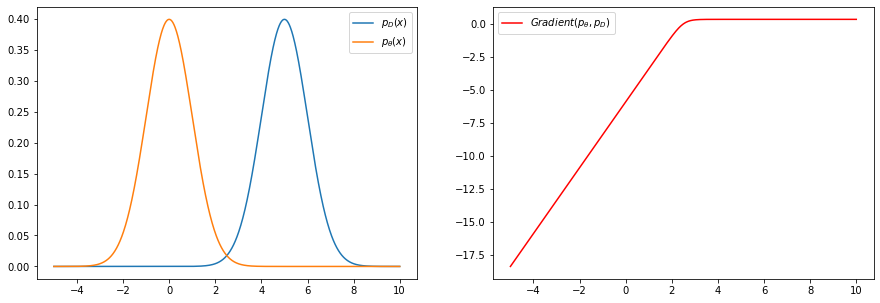

In [66]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

from math import *

X = np.linspace(-5, 10,1000)
P = norm.pdf(X, loc=0, scale=1)
Q = norm.pdf(X, loc=5, scale=1)

def Gradient(p, q):
    return   0.5*log(2*q/(q+p)) 


g = []
for i in range(X.shape[0]):
    p, q,  = P[i], Q[i]
    g.append(Gradient(p, q))
    

plt.figure(figsize=(15, 5))
plt.subplot(1,2,1)
plt.plot(X, Q, label=r'$p_D(x)$');
plt.plot(X, P, label=r'$p_\theta(x)$')
plt.legend()
plt.subplot(1,2,2)
plt.plot(X, g, c='red', label=r'$Gradient(p_\theta, p_D)$')
plt.legend()

Having the generator trained to maximize $\mathcal{L}_D$ is equivalent to setting its training loss to $ \mathcal{L}_G = \mathbb{E}_{p_\theta} \log(1-D(x)) $.

**Q5: This loss only gives feedback to the generator on samples it generated, what problem may this cause?**

> The generator learns to produce a density in regions where $log(1-D(x))=0$ meaning in regions where $D(x)=1$. Since it only has feedback on samples it generated, if a sample is generated where $D(x)=1$, then the generator will generate all samples on this single point, meaning that there will be a lack of diversity. 

__Now let's summurize the two previous questions. Question 4 shows that if we train too much the discriminator, the gradient vanishes before the generator becomes good and the generator is never able to produce good data. If we train the generator too much, the samples it produces are concentrated on single points and lack diversity. This shows the need to carefully control the training ratio.__

We will now work on implementing a GAN on a simple toy problem, to get a feeling of its behavior and test our theoretical insights. For this we will use the `pytorch` library.

While a real problem would be generating images for example (each datapoint $x$ would then be a different image), this is a kind of task that easily requires intensive CPU/GPU power, and image datasets are difficult to visualize from a geometric point of view (even small images contains hundreds of pixels, and nobody can visualize points in a 100-dimensional space). So instead we will focus on points in the plane: each datapoint $x$ will actually be a couple of numbers $(x1, x2)$, and our target dataset will be a 2D two-moons shape with some noise.

In [67]:
import torch
from math import *
from sklearn import datasets
import numpy as np
import torch.nn.functional as F

# Our dataset is mathematically defined, we can generate batches on the fly and enjoy
# an infinite-size dataset
def generate_batch(batchlen):
    """This function generates a batch of length 'batchlen' from the dataset
    """
    data = datasets.make_moons(n_samples=batchlen, noise=0.05)[0].astype(np.float32)
    return torch.from_numpy(data)

Let's plot a large batch, to see what the dataset looks like.

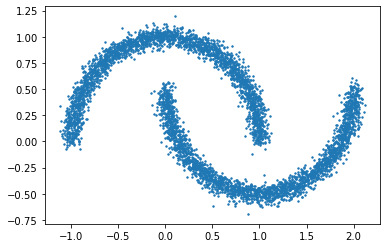

In [68]:
%matplotlib inline
import matplotlib.pyplot as plt

batch = generate_batch(5000)

plt.scatter(batch[:,0], batch[:,1], s=2.0)
plt.show()

We now need to define our two neural networks, the generator and the discriminator. The generator will take as input a value $z$ sampled from a Gaussian prior, and output a value $x$ (thus a couple $(x_1,x_2)$). The discriminator takes as input a value $x$, and is a binary classifier.

In [102]:
import torch.nn as nn
import torch.nn.functional as F

# Choose a value for the prior dimension
PRIOR_N = 2

# Define the generator
class Generator(nn.Module):
    def __init__(self, width=64, depth=0):
        super().__init__()
        
        self.width = width
        self.depth = depth
        
        self.fc1 = nn.Linear(PRIOR_N, width)
        
        self.midlayers = []
        
        for i in range(self.depth):
            self.midlayers.append(nn.Linear(width,width))
        
        
        self.fcn = nn.Linear(width, 2)
    
    def __call__(self, z):
        h = F.relu(self.fc1(z))
        
        for i in range(self.depth):
            h = F.relu(self.midlayers[i](h))
        
        return self.fcn(h)
    
    def generate(self, batchlen):
        z = torch.normal(torch.zeros(batchlen, PRIOR_N), 1.0)
        return self.__call__(z)
    

# Define the discriminator
class Discriminator(nn.Module):
    def __init__(self, width=64, depth=0):
        super().__init__()
        
        self.width = width
        self.depth = depth
        
        self.fc1 = nn.Linear(PRIOR_N, width)
        
        self.midlayers = []
        
        for i in range(self.depth):
            self.midlayers.append(nn.Linear(width,width))
        
        
        self.fcn = nn.Linear(width, 1)
        
    def __call__(self, x):
        h = F.relu(self.fc1(x))
        
        for i in range(self.depth):
            h = F.relu(self.midlayers[i](h))
        
        return self.fcn(h)

With these classes in shape, now is only needed the training loop. To stick with the mathematical GAN framework, we should train the discriminator until convergence between each training step of the generator. This is not practical for two reasons: first it takes a lot of time, and second if the discriminator is too good, it will generate vanishing gradients to the generator (as seen in **Q4**).

We will thus train the discriminator a fixed number of times between each training iteration of the generator.

In [212]:
# Number of times to train the discriminator between two generator steps

# Total number of training iterations for the generator
N_ITER = 20001
# Batch size to use
BATCHLEN = 128

def train(width, depth, train_ratio):
    generator = Generator(width,depth)
    optim_gen = torch.optim.Adam(generator.parameters(), lr=0.001, betas=(0.5,0.9))
    discriminator = Discriminator(width, depth)
    optim_disc = torch.optim.Adam(discriminator.parameters(), lr=0.001, betas=(0.5,0.9))

    for i in range(N_ITER):
        # train the discriminator
        for _ in range(train_ratio):
            discriminator.zero_grad()
            real_batch = generate_batch(BATCHLEN)
            fake_batch = generator.generate(BATCHLEN)
            #
            # == COMPUTE THE DISCRIMINATOR LOSS HERE ==
            #
            disc_loss = torch.mean(-F.logsigmoid(discriminator(real_batch)) - F.logsigmoid(-discriminator(fake_batch)))
            disc_loss.backward()
            optim_disc.step()
        # train the generator
        generator.zero_grad()
        fake_batch = generator.generate(BATCHLEN)
        #
        # == COMPUTE THE GENERATOR LOSS HERE
        #
        gen_loss =  torch.mean(F.logsigmoid(-discriminator(fake_batch)))
        gen_loss.backward()
        optim_gen.step()
        if i%10000 == 0:
            print('step {}: discriminator: {:.3e}, generator: {:.3e}'.format(i, float(disc_loss), float(gen_loss)))
            # plot the result
            real_batch = generate_batch(1024)
            fake_batch = generator.generate(1024).detach()
            plt.scatter(real_batch[:,0], real_batch[:,1], s=2.0, label='real data')
            plt.scatter(fake_batch[:,0], fake_batch[:,1], s=2.0, label='fake data')
            plt.legend()
            plt.show()

Complete the previous code and train your model.

Depending on your choice of parameters, the training may not go well at all, with the generator completely collapsing quickly at the beginning of the training. It has been observed by the litterature that the generator's loss $\mathcal{L}_G = \mathbb{E}_{p_\theta} \log(1-D(x))$ is often to blame.

__Change in the code :__

> I changed the following in the code : I changed the classes so that the initialization takes as parameter the depth, width and train_ratio. I also created a function to train the model with these parameters. Concerning the loss, I used the function F.logsigmoid from Pytorch. 
> Noting g the logsigmoid function, we therefore have
$$\begin{aligned}
\mathcal{L}_D 
&= \mathbb{E}_{p_D} \left[ -\log \sigma(D(x)) \right] + \mathbb{E}_{p_\theta} \left[ -\log \left(1 - \sigma(D(x)) \right) \right] \\
&= \mathbb{E}_{p_D} \left[ -\log \left( \frac{1}{1 + e^{-D(x)}} \right) \right] + \mathbb{E}_{p_\theta} \left[ -\log \left(1 - \frac{1}{1 + e^{-D(x)}} \right) \right] \\
&= \mathbb{E}_{p_D} \left[ -g(D(x)) \right] + \mathbb{E}_{p_\theta} \left[ -g(-D(x)) \right] \\
&= \mathbb{E}_{p_D} \left[ -g(D(x)) \right] + \mathbb{E}_{p_\theta} \left[ -g(-D(x)) \right]
\end{aligned}$$


> As well as $ \mathcal{L}_G = \mathbb{E}_{p_D} \left[ g(-D(x)) \right]$ wich we have changed in the code.

step 0: discriminator: 1.385e+00, generator: -8.615e-01


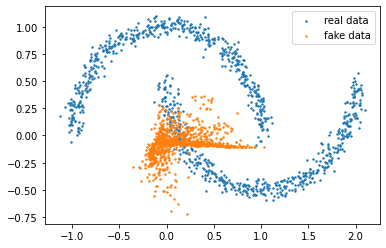

step 10000: discriminator: 1.372e+00, generator: -6.933e-01


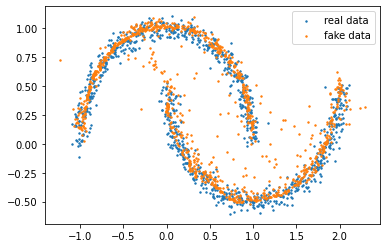

step 20000: discriminator: 1.380e+00, generator: -6.848e-01


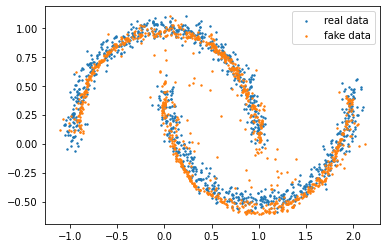

In [213]:
train(width=64,depth=0,train_ratio = 3)

**Q6: Why could we anticipate that this loss could cause this?**

> When the discriminator is trained very well, $D(x) \simeq  0$ and log(1-D(x)) is at a local maximuù, meaning that the gradient vanishes and the generator does not improve. We therefore need to change the function for a function where the gradient is very steep where $D(x) \simeq 0$. For this the choice of -log is perfect as its gradient is infinite in 0.

This issue is solved by replacing the generator loss by an alternative loss: $\mathcal{L}_G = \mathbb{E}_{p_\theta} [ -\log D(x) ]$ to avoid gradient vanishing.

**Q7: Inspect the impact of these different factors:**

- depth / width of the generator network
- depth / width of the discriminator network
- impact of `TRAIN_RATIO`

__Let's first plot the results for the different training parameters : Depth browses [0,1,2], Width browses [32,64,128], and Train_ratio browses [2,3,4,5]__

step 0: discriminator: 1.363e+00, generator: -7.348e-01


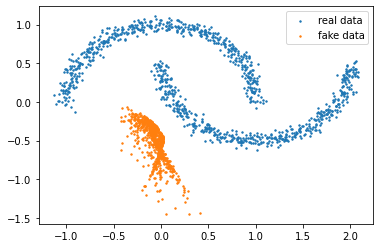

step 10000: discriminator: 1.387e+00, generator: -6.874e-01


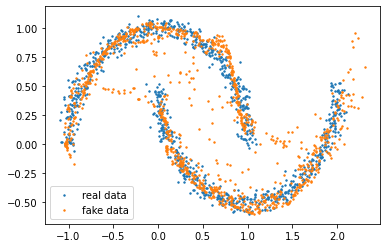

step 20000: discriminator: 1.386e+00, generator: -6.844e-01


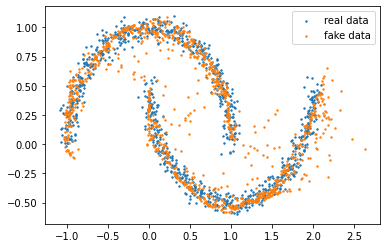

width : 32, depth: 0, training_ratio: 2, training time : 85 seconds
step 0: discriminator: 1.452e+00, generator: -8.950e-01


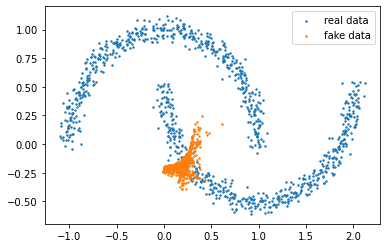

step 10000: discriminator: 1.368e+00, generator: -6.850e-01


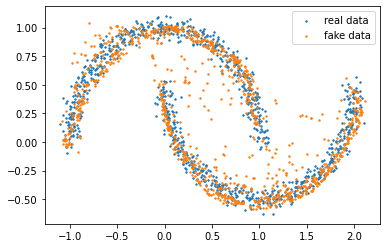

step 20000: discriminator: 1.378e+00, generator: -6.982e-01


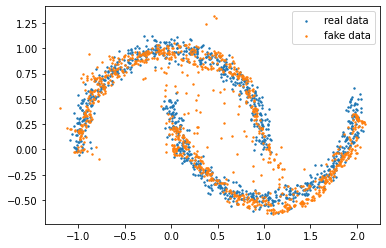

width : 32, depth: 0, training_ratio: 3, training time : 118 seconds
step 0: discriminator: 1.407e+00, generator: -6.571e-01


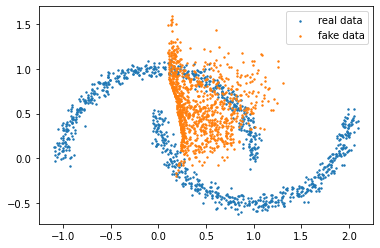

step 10000: discriminator: 1.377e+00, generator: -6.886e-01


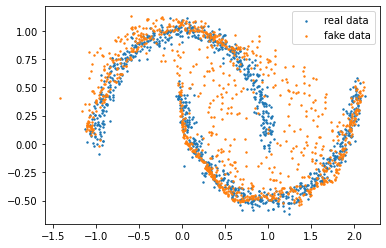

step 20000: discriminator: 1.380e+00, generator: -6.889e-01


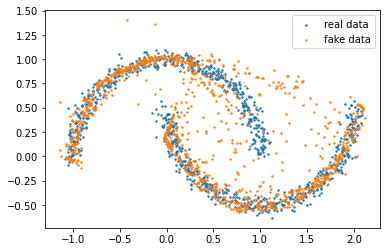

width : 32, depth: 0, training_ratio: 4, training time : 145 seconds
step 0: discriminator: 1.405e+00, generator: -7.658e-01


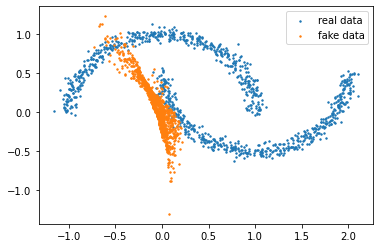

step 10000: discriminator: 1.378e+00, generator: -6.709e-01


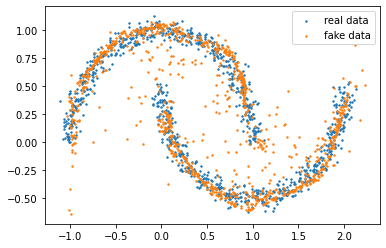

step 20000: discriminator: 1.357e+00, generator: -6.769e-01


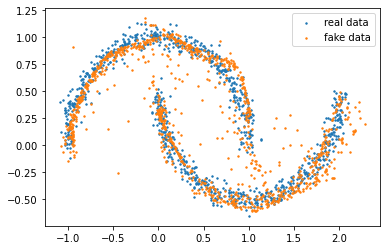

width : 32, depth: 0, training_ratio: 5, training time : 179 seconds
step 0: discriminator: 1.359e+00, generator: -7.721e-01


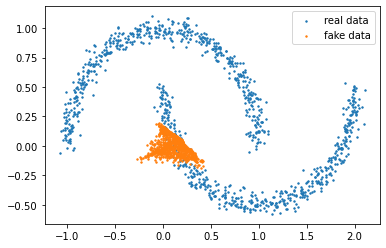

step 10000: discriminator: 1.385e+00, generator: -6.848e-01


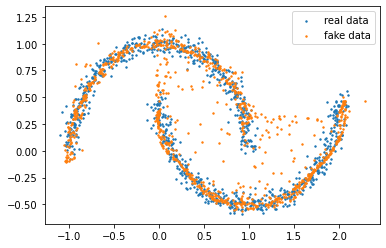

step 20000: discriminator: 1.387e+00, generator: -6.910e-01


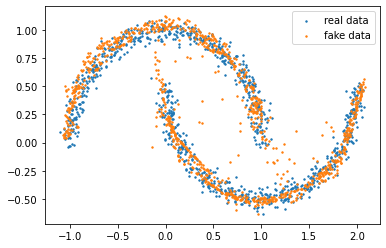

width : 32, depth: 1, training_ratio: 2, training time : 116 seconds
step 0: discriminator: 1.381e+00, generator: -7.309e-01


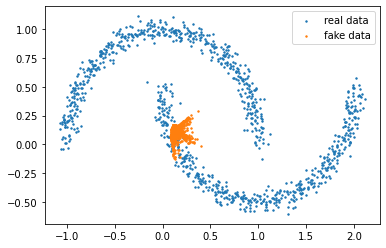

step 10000: discriminator: 1.387e+00, generator: -6.858e-01


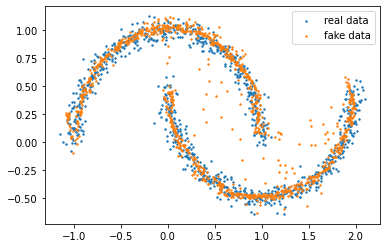

step 20000: discriminator: 1.383e+00, generator: -6.855e-01


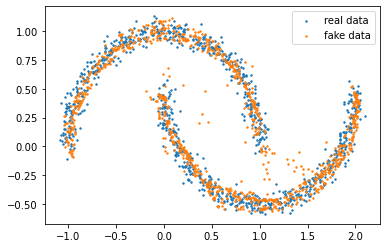

width : 32, depth: 1, training_ratio: 3, training time : 151 seconds
step 0: discriminator: 1.392e+00, generator: -7.919e-01


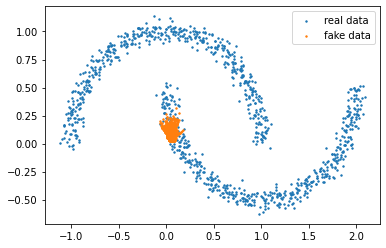

step 10000: discriminator: 1.388e+00, generator: -6.951e-01


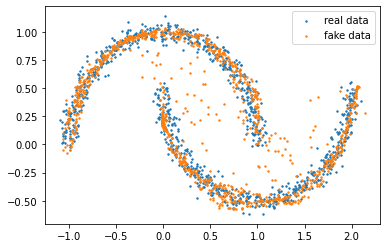

step 20000: discriminator: 1.377e+00, generator: -6.905e-01


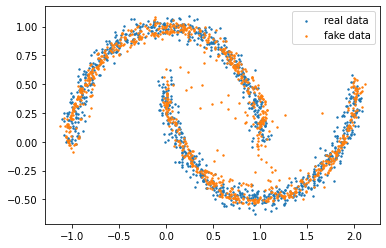

width : 32, depth: 1, training_ratio: 4, training time : 202 seconds
step 0: discriminator: 1.440e+00, generator: -6.121e-01


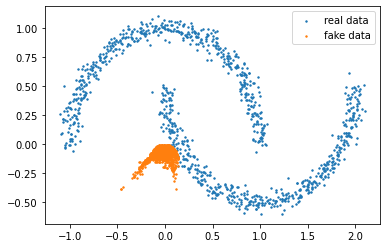

step 10000: discriminator: 1.388e+00, generator: -6.971e-01


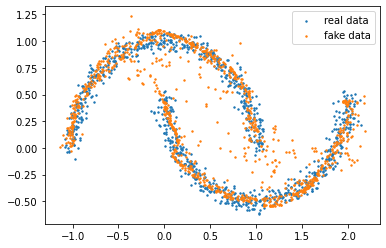

step 20000: discriminator: 1.388e+00, generator: -6.854e-01


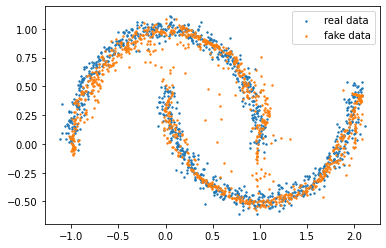

width : 32, depth: 1, training_ratio: 5, training time : 235 seconds
step 0: discriminator: 1.374e+00, generator: -6.943e-01


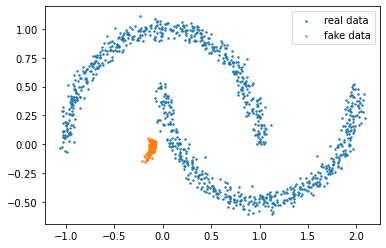

step 10000: discriminator: 1.381e+00, generator: -6.949e-01


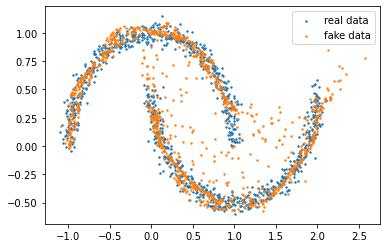

step 20000: discriminator: 1.383e+00, generator: -6.957e-01


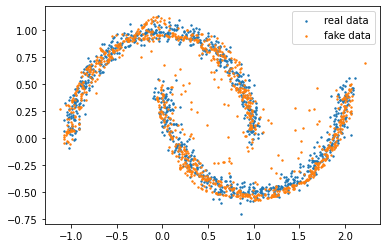

width : 32, depth: 2, training_ratio: 2, training time : 127 seconds
step 0: discriminator: 1.398e+00, generator: -7.518e-01


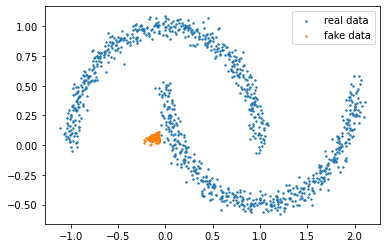

step 10000: discriminator: 1.375e+00, generator: -6.714e-01


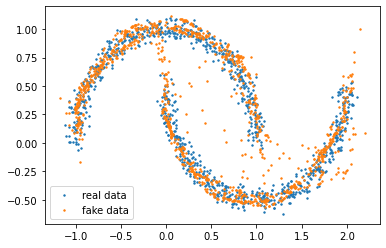

step 20000: discriminator: 1.381e+00, generator: -6.919e-01


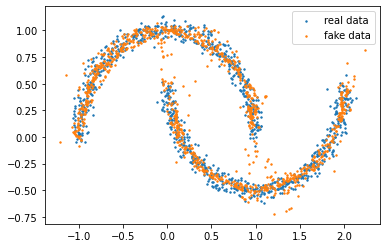

width : 32, depth: 2, training_ratio: 3, training time : 173 seconds
step 0: discriminator: 1.383e+00, generator: -7.023e-01


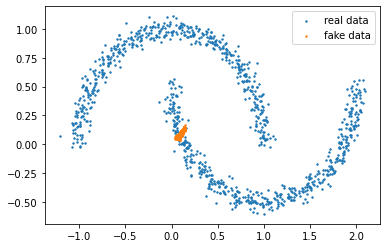

step 10000: discriminator: 1.368e+00, generator: -6.937e-01


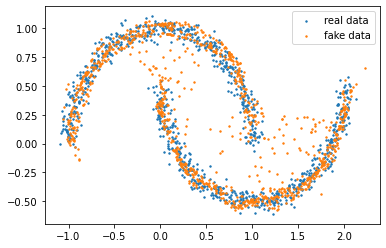

step 20000: discriminator: 1.379e+00, generator: -6.785e-01


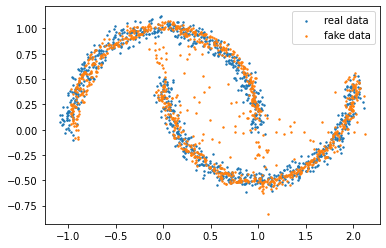

width : 32, depth: 2, training_ratio: 4, training time : 223 seconds
step 0: discriminator: 1.380e+00, generator: -7.275e-01


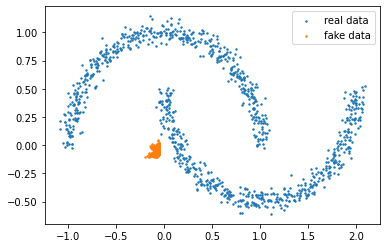

step 10000: discriminator: 1.385e+00, generator: -6.937e-01


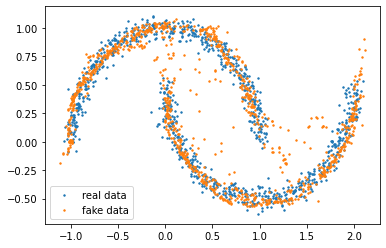

step 20000: discriminator: 1.385e+00, generator: -6.933e-01


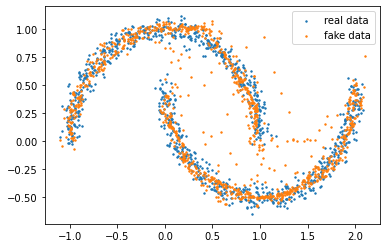

width : 32, depth: 2, training_ratio: 5, training time : 284 seconds
step 0: discriminator: 1.368e+00, generator: -6.151e-01


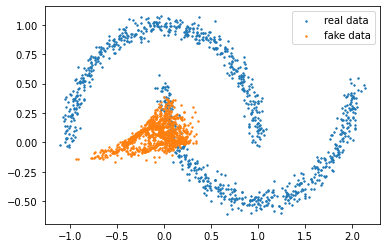

step 10000: discriminator: 1.387e+00, generator: -6.966e-01


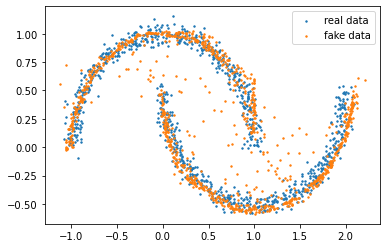

step 20000: discriminator: 1.393e+00, generator: -6.829e-01


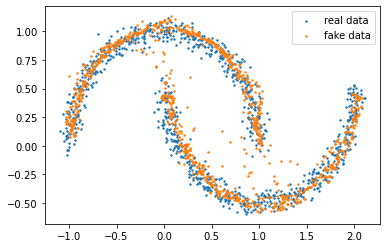

width : 64, depth: 0, training_ratio: 2, training time : 90 seconds
step 0: discriminator: 1.376e+00, generator: -7.718e-01


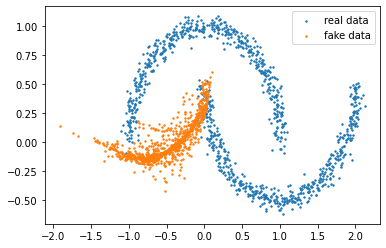

step 10000: discriminator: 1.392e+00, generator: -6.954e-01


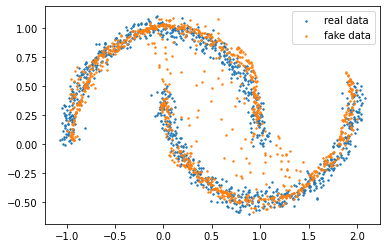

step 20000: discriminator: 1.389e+00, generator: -6.786e-01


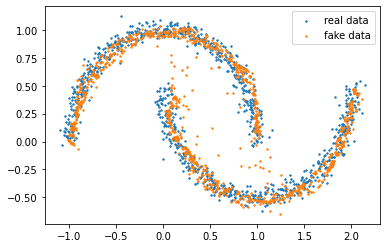

width : 64, depth: 0, training_ratio: 3, training time : 122 seconds
step 0: discriminator: 1.443e+00, generator: -6.428e-01


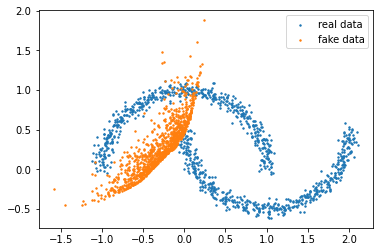

step 10000: discriminator: 1.375e+00, generator: -6.793e-01


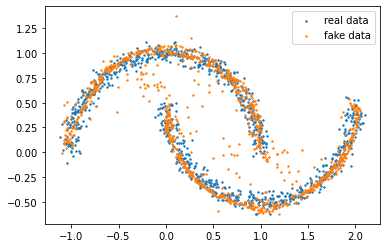

step 20000: discriminator: 1.377e+00, generator: -6.989e-01


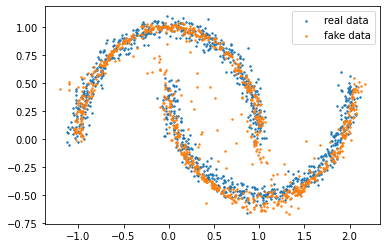

width : 64, depth: 0, training_ratio: 4, training time : 160 seconds
step 0: discriminator: 1.351e+00, generator: -6.222e-01


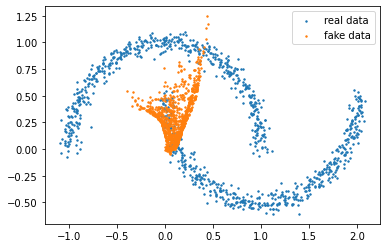

step 10000: discriminator: 1.364e+00, generator: -6.905e-01


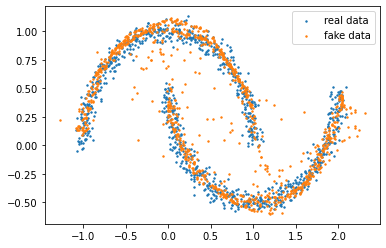

step 20000: discriminator: 1.386e+00, generator: -6.910e-01


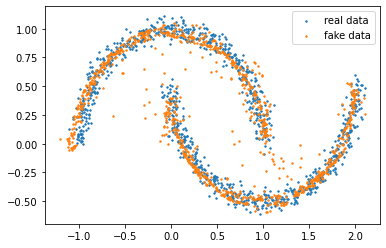

width : 64, depth: 0, training_ratio: 5, training time : 197 seconds
step 0: discriminator: 1.381e+00, generator: -6.899e-01


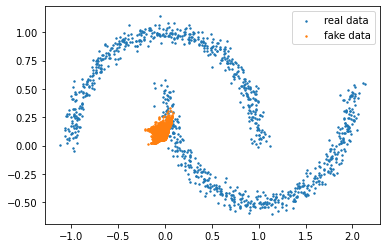

step 10000: discriminator: 1.388e+00, generator: -6.817e-01


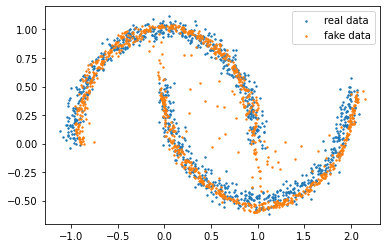

step 20000: discriminator: 1.387e+00, generator: -6.972e-01


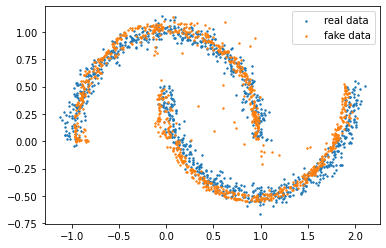

width : 64, depth: 1, training_ratio: 2, training time : 130 seconds
step 0: discriminator: 1.370e+00, generator: -7.112e-01


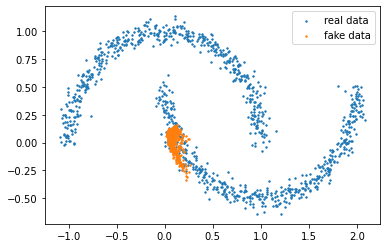

step 10000: discriminator: 1.387e+00, generator: -6.941e-01


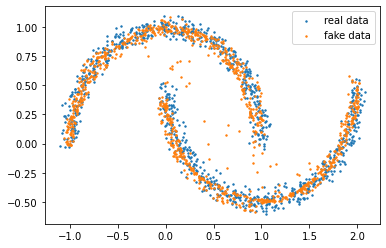

step 20000: discriminator: 1.386e+00, generator: -6.926e-01


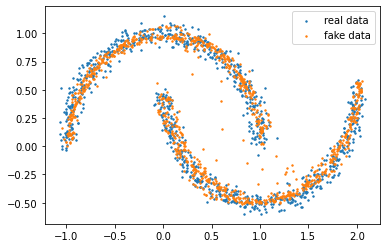

width : 64, depth: 1, training_ratio: 3, training time : 174 seconds
step 0: discriminator: 1.352e+00, generator: -7.093e-01


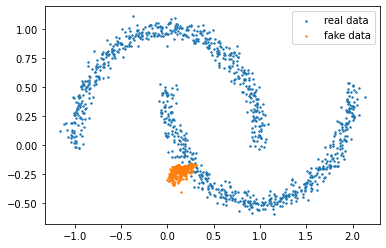

step 10000: discriminator: 1.384e+00, generator: -6.817e-01


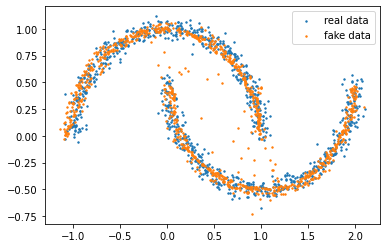

step 20000: discriminator: 1.385e+00, generator: -7.040e-01


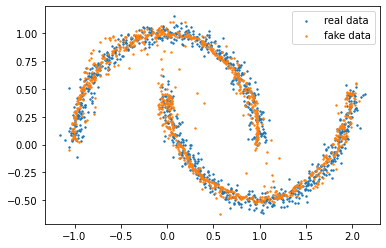

width : 64, depth: 1, training_ratio: 4, training time : 222 seconds
step 0: discriminator: 1.350e+00, generator: -7.006e-01


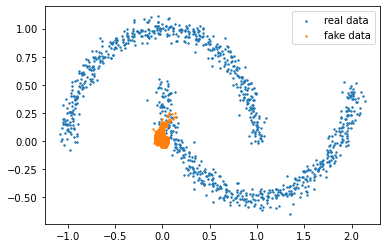

step 10000: discriminator: 1.385e+00, generator: -6.868e-01


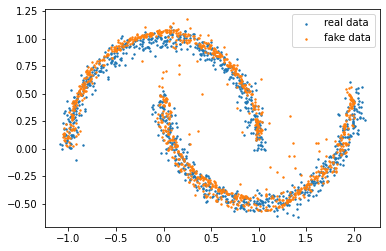

step 20000: discriminator: 1.385e+00, generator: -6.963e-01


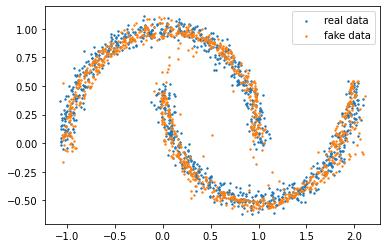

width : 64, depth: 1, training_ratio: 5, training time : 281 seconds
step 0: discriminator: 1.401e+00, generator: -6.473e-01


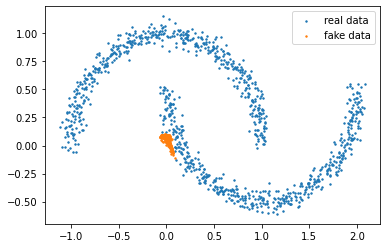

step 10000: discriminator: 1.376e+00, generator: -6.971e-01


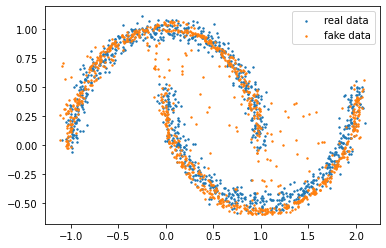

step 20000: discriminator: 1.389e+00, generator: -6.986e-01


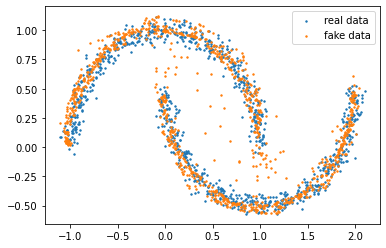

width : 64, depth: 2, training_ratio: 2, training time : 184 seconds
step 0: discriminator: 1.381e+00, generator: -6.815e-01


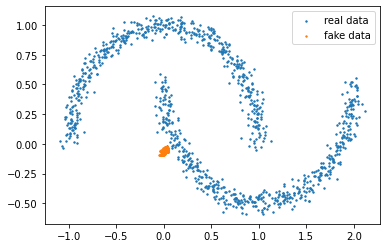

step 10000: discriminator: 1.385e+00, generator: -7.018e-01


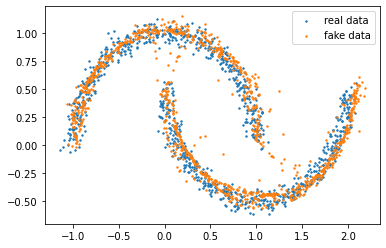

step 20000: discriminator: 1.385e+00, generator: -6.811e-01


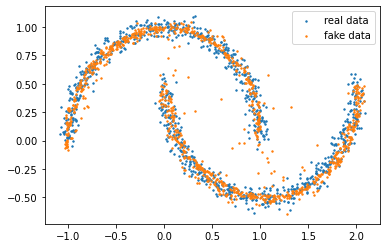

width : 64, depth: 2, training_ratio: 3, training time : 231 seconds
step 0: discriminator: 1.387e+00, generator: -6.673e-01


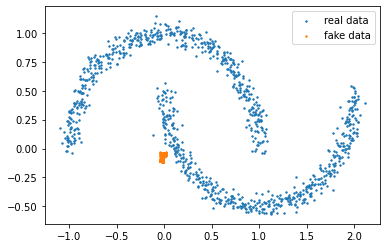

step 10000: discriminator: 1.382e+00, generator: -6.849e-01


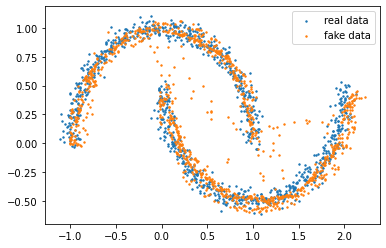

step 20000: discriminator: 1.385e+00, generator: -6.913e-01


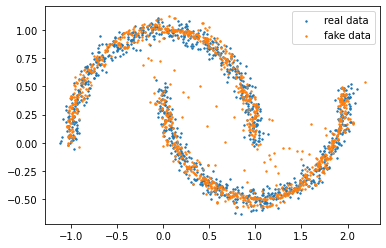

width : 64, depth: 2, training_ratio: 4, training time : 296 seconds
step 0: discriminator: 1.394e+00, generator: -6.269e-01


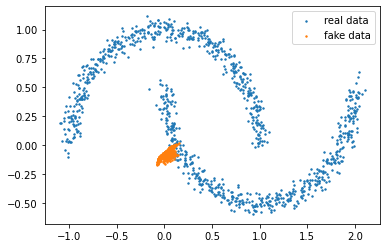

step 10000: discriminator: 1.380e+00, generator: -6.801e-01


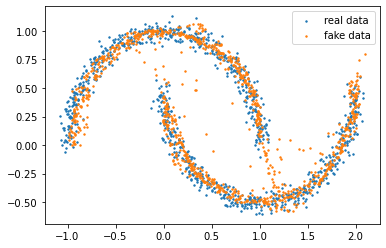

step 20000: discriminator: 1.392e+00, generator: -6.912e-01


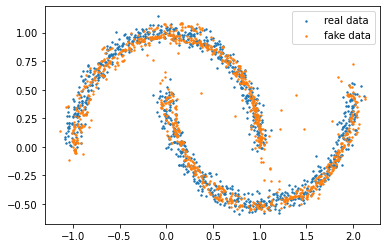

width : 64, depth: 2, training_ratio: 5, training time : 354 seconds
step 0: discriminator: 1.336e+00, generator: -7.211e-01


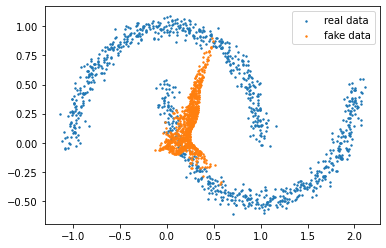

step 10000: discriminator: 1.385e+00, generator: -6.990e-01


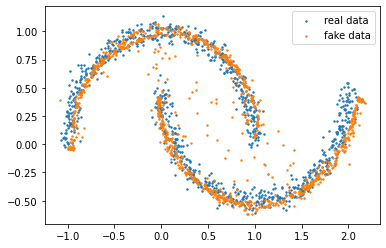

step 20000: discriminator: 1.392e+00, generator: -6.963e-01


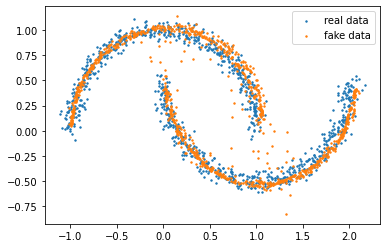

width : 128, depth: 0, training_ratio: 2, training time : 99 seconds
step 0: discriminator: 1.345e+00, generator: -7.726e-01


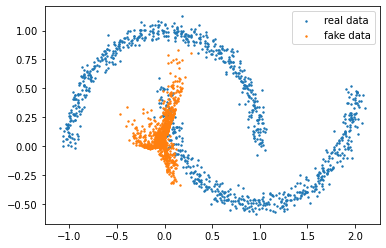

step 10000: discriminator: 1.384e+00, generator: -7.093e-01


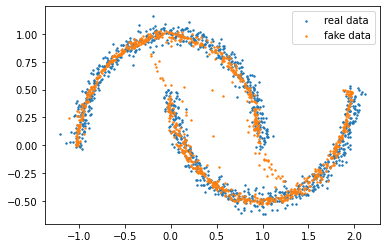

step 20000: discriminator: 1.385e+00, generator: -6.912e-01


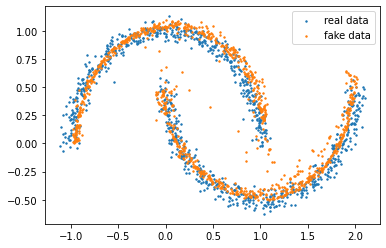

width : 128, depth: 0, training_ratio: 3, training time : 139 seconds
step 0: discriminator: 1.384e+00, generator: -6.845e-01


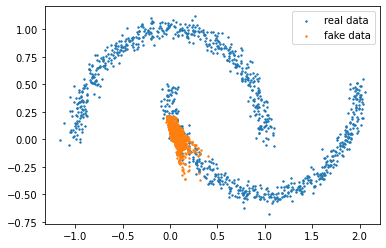

step 10000: discriminator: 1.384e+00, generator: -6.897e-01


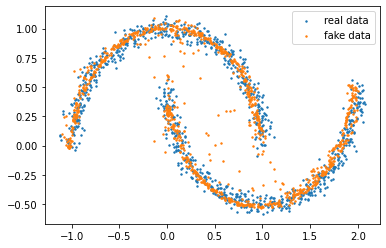

step 20000: discriminator: 1.384e+00, generator: -6.921e-01


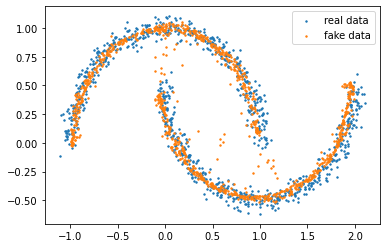

width : 128, depth: 0, training_ratio: 4, training time : 187 seconds
step 0: discriminator: 1.325e+00, generator: -5.994e-01


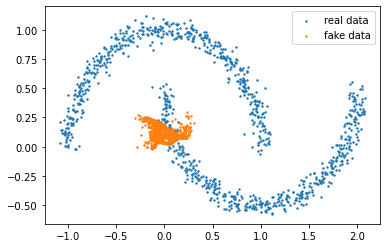

step 10000: discriminator: 1.382e+00, generator: -6.864e-01


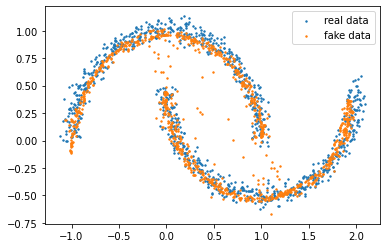

step 20000: discriminator: 1.378e+00, generator: -6.902e-01


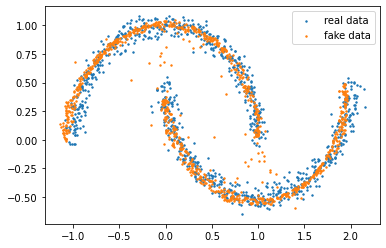

width : 128, depth: 0, training_ratio: 5, training time : 221 seconds
step 0: discriminator: 1.371e+00, generator: -6.834e-01


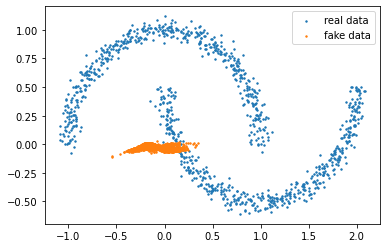

step 10000: discriminator: 1.385e+00, generator: -6.861e-01


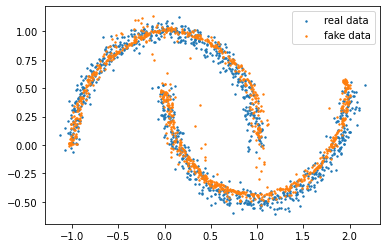

step 20000: discriminator: 1.384e+00, generator: -6.911e-01


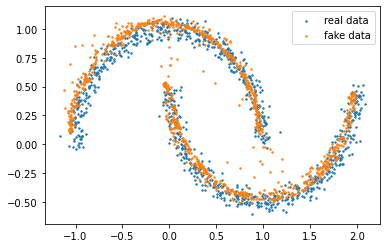

width : 128, depth: 1, training_ratio: 2, training time : 171 seconds
step 0: discriminator: 1.427e+00, generator: -6.838e-01


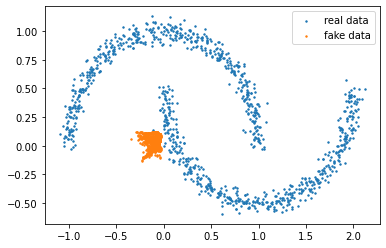

step 10000: discriminator: 1.382e+00, generator: -6.862e-01


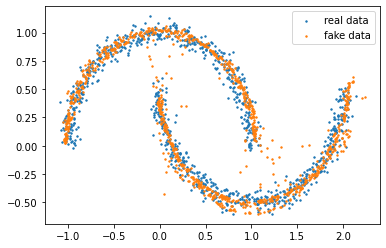

step 20000: discriminator: 1.385e+00, generator: -6.954e-01


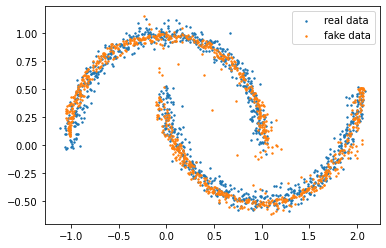

width : 128, depth: 1, training_ratio: 3, training time : 234 seconds
step 0: discriminator: 1.385e+00, generator: -6.890e-01


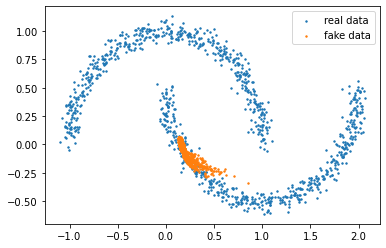

step 10000: discriminator: 1.382e+00, generator: -6.879e-01


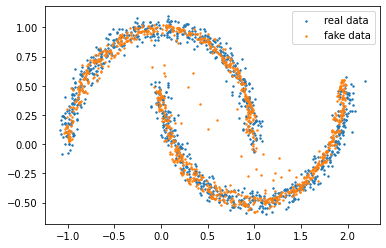

step 20000: discriminator: 1.373e+00, generator: -6.945e-01


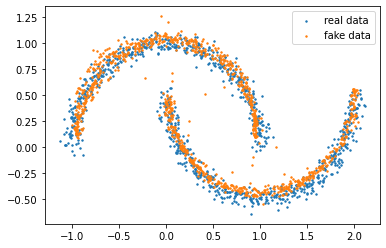

width : 128, depth: 1, training_ratio: 4, training time : 311 seconds
step 0: discriminator: 1.382e+00, generator: -7.513e-01


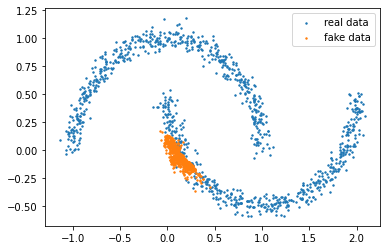

step 10000: discriminator: 1.386e+00, generator: -6.795e-01


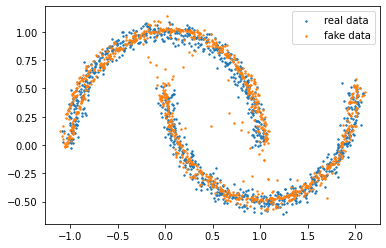

step 20000: discriminator: 1.370e+00, generator: -6.970e-01


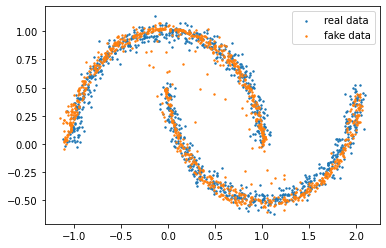

width : 128, depth: 1, training_ratio: 5, training time : 382 seconds
step 0: discriminator: 1.386e+00, generator: -6.603e-01


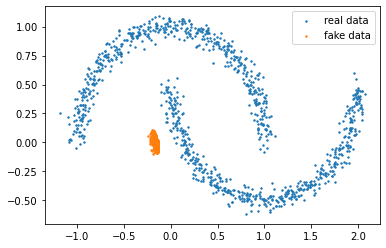

step 10000: discriminator: 1.386e+00, generator: -6.910e-01


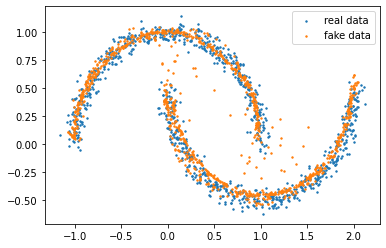

step 20000: discriminator: 1.386e+00, generator: -7.002e-01


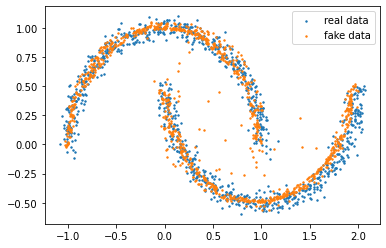

width : 128, depth: 2, training_ratio: 2, training time : 242 seconds
step 0: discriminator: 1.398e+00, generator: -6.690e-01


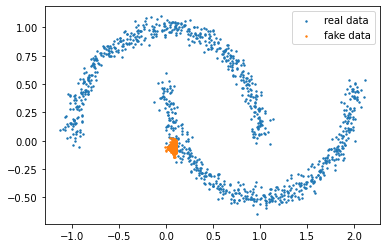

step 10000: discriminator: 1.382e+00, generator: -6.906e-01


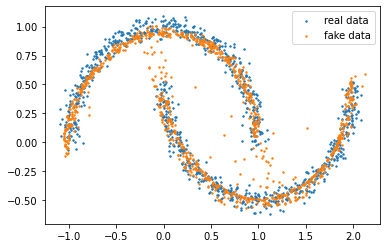

step 20000: discriminator: 1.385e+00, generator: -6.916e-01


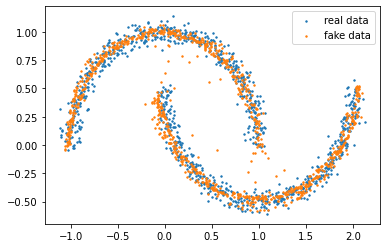

width : 128, depth: 2, training_ratio: 3, training time : 327 seconds
step 0: discriminator: 1.391e+00, generator: -7.401e-01


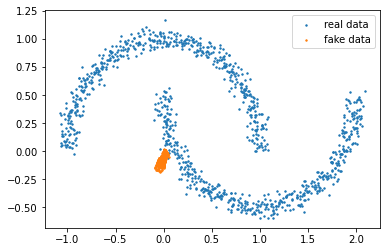

step 10000: discriminator: 1.388e+00, generator: -6.890e-01


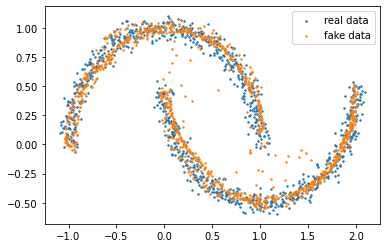

step 20000: discriminator: 1.386e+00, generator: -6.975e-01


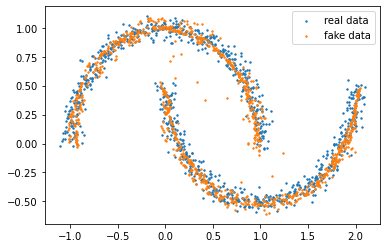

width : 128, depth: 2, training_ratio: 4, training time : 424 seconds
step 0: discriminator: 1.395e+00, generator: -7.026e-01


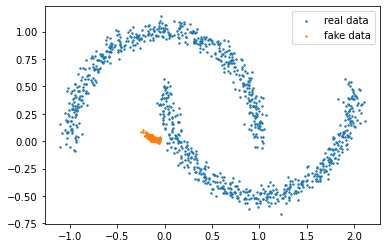

step 10000: discriminator: 1.368e+00, generator: -6.946e-01


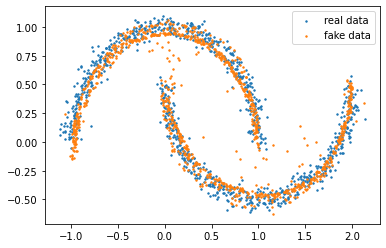

step 20000: discriminator: 1.387e+00, generator: -6.902e-01


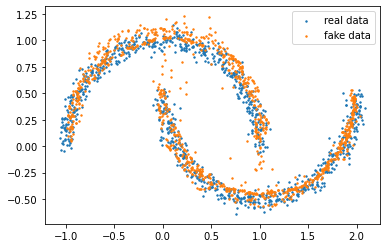

width : 128, depth: 2, training_ratio: 5, training time : 509 seconds


In [119]:
import time
startime = time.time()
for width in [32,64,128]:
    for depth in [0,1,2]:
        for train_ratio in [2,3,4,5]:
            print("="*80)
            train(width, depth, train_ratio)
            print('width : {}, depth: {}, training_ratio: {}, training time : {} seconds'.format(width, depth, train_ratio, int(time.time()-startime)))
            print("="*80)
            startime = time.time()

After careful examination of our plots, we conclude two things. First, the final generator loss and discriminator loss do not seem to give a good indication of the quality of the generated data. Indeed some poor quality generated data sometimes have better losses than high-quality generated data. Second, a depth equal to 1, a training ratio around 3, and a width between 64 and 128 give the best results. __Finally, the ideal combination that we come up with is Depth = 1, Training_Ratio = 3, Width = 64.__ 

For further readings on GANs, you can see the following papers:

- Generative Adversarial Networks *(Goodfellow et al.)*: [arXiv:1406.2661](https://arxiv.org/abs/1406.2661)
- Unsupervised Representation Learning with Deep Convolutional Generative Adversarial Networks *(Radford et al.)*: [arXiv:1511.06434](https://arxiv.org/abs/1511.06434)
- A Style-Based Generator Architecture for Generative Adversarial Networks *(Karras et al.)* [arxiv:1812.04948v3](https://arxiv.org/abs/1812.04948v3)

### Variational AutoEncoders

Another well-known approach to generative modelling is embodied by Variational AutoEncoders (VAEs). While the generative model itself and the procedure to sample it is similar to GANs, the way it is trained is not.

The main goal of VAEs is to optimize the likelihood of the real data according to the generative model. In other words, maximize $\mathbb{E}_{p_D} \left[\log p_\theta(x) \right ]$, which is equivalent to minimizing $D_{KL}(p_D \| p_\theta)$.
$$D_{KL}(p_D \| p_\theta) = \mathbb{E}_{p_D}\left[ log(\frac{p_D}{p_\theta}) \right]$$

**Q8: Prove this equivalence.**

> (Write your answer here)

However, the classes of distributions for which $\log p_\theta(x)$ can be analytically computed and optimized is very restricted, and not suitable for real world problems. The main idea of the VAE is thus to introduce a latent variable $z$ and decompose the distribution as: $p_\theta(x, z) = p_\theta(x | z) p(z)$. Here $p(z)$ is some fixed prior and $p_\theta(x | z)$ is a simple distribution whose parameters are the output of a neural network.

For example, you could have $p(z)$ be a standard $\mathcal{N}(0;1)$ and $p_\theta(x | z)$ be defined as a gaussian $\mathcal{N}(\mu_\theta(z); \sigma_\theta(z))$ where $\mu_\theta(z)$ and $\sigma_\theta(z)$ are created by the neural network you will train. In this case, the resulting distribution $p_\theta(x) = \int_z p_\theta(x|z)p(z)dz$ is an infinite mixture of Gaussians, which is a much more expressive class of distributions.

Now, this cannot stop here, as we are not able to analitically compute the density $p_\theta(x)$. The second main idea of the VAE is to introduce another, auxilliary distribution: $q_\phi(z | x)$, which will be modelled by a neural network similarly to $p_\theta(x | z)$. Introducing it allows us to create a lower bound for $\log p_\theta(x)$:

$$\log p_\theta(x) = \mathbb{E}_{z \sim q_\phi} \log p_\theta(x) = \mathbb{E}_{z \sim q_\phi} \left[ \log p_\theta(x) \frac {q_\phi(z|x)}{q_\phi(z|x)} \right]$$

Following Bayes theorem, $p_\theta(x) p_\theta(z|x) = p_\theta(x, z) = p_\theta(x|z) p(z)$, so we get:

$$\log p_\theta(x) = \mathbb{E}_{z \sim q_\phi} \left[ \log \frac{p_\theta(x|z) p(z)}{p_\theta(z|x)} \frac {q_\phi(z|x)}{q_\phi(z|x)} \right]$$

Re-organizing the terms:

$$\log p_\theta(x) = \mathbb{E}_{z \sim q_\phi} \log \frac{q_\phi(z|x)}{p_\theta(z|x)} + \mathbb{E}_{z \sim q_\phi} \log \frac{p(z)}{q_\phi(z|x)} + \mathbb{E}_{z \sim q_\phi} \log p_\theta(x | z)$$

This can be re-expressed like so:

$$\log p_\theta(x) = D_{KL}(q_\phi(z | x) \| p_\theta(z | x)) - D_{KL}(q_\phi(z | x) \| p(z)) + \mathbb{E}_{z \sim q_\phi} \log p_\theta(x|z)$$

The 3 terms of this equality can be interpreted like so:

- the first term measures how much $q_\phi(z | x)$ is similar to $p_\theta(z | x)$, or in other words is a good inverse of $p_\theta(x | z)$
- the second term measures how similar $q_\phi(z|x)$ is from the latent prior $p(z)$
- the third term is linked to how likely $p_\theta$ is to yield the given $x$ when $z$ is sampled from $q_\phi(z | x)$ rather than $p(z)$

It is interesting to note that the first term, being a KL-divergence is always positive. As such the combination of the last two terms forms a lower bound of $\log p_\theta(x)$ which *can* be computed and used as a training objective. This bound is called the *Evidence Lower-Bound (ELBO)*. Simply flipping its sign can make it into a loss that can be minimized by gradient descent:

$$ \mathcal{L}_{ELBO} = D_{KL}(q_\phi(z | x) \| p(z)) + \mathbb{E}_{z \sim q_\phi} [ - \log p_\theta(x|z) ]$$

From this formulation comes the parallel with auto-encoders that give the VAE its name: $q_\phi(z | x)$ can be seen as a *probabilistic encoder* from the data $x$ to the latent space $z$, and $p_\theta(x | z)$ can be seen as a *probabilistic decoder* from the latent space $z$ to the data $x$. In this case the second term of $\mathcal{L}_{ELBO}$ is the loss measuring the reconstruction quality of the auto-encoder, and the first term can be seens as a regularization of the latent space.

![VAE](vae-gaussian.png)

**Q9: We can see that $p(z)$ is never sampled during the training process, how can that be a problem?**

> (Write your answer here, what will be the influence on data generation by VAE)

A typical choice to represent $q_\phi(z | x)$ is to use a diagonal Gaussian distribution $\mathcal{N}(\mu_\phi(x); Diag(\sigma_\phi^2(x)))$, which makes the KL-divergence term of $\mathcal{L}_{ELBO}$ analytically computable.

**Q10: Assuming $p(z)$ is a $\mathcal{N}(0; Id)$ gaussian, what is the value of $D_{KL}(q_\phi(z | x) \| p(z))$?**

> (Write your answer here)

We will also model $p_\theta(x | z)$ as a diagonal Gaussian $\mathcal{N}(\mu_\theta(z); Diag(\sigma_\theta^2(z)))$.


**Note:** For the following, be careful about the difference between $\mu_\phi, \sigma_\phi$ which define the Gaussian distribution of the *encoder* $q_\phi$ and $\mu_\theta, \sigma_\theta$ which define the Gaussian distribution of the *decoder* $p_\theta$.

**Q11: What is the expression of $-\log p_\theta(x | z)$ for given $x$ and $z$?**

> (Write your answer here)

We will build and train a VAE using the same dataset as previously, in order to compare its behavior to GANs. For numerical stability, we will interpret the output of the encoder and decoder networks as $(\mu, \log\sigma^2)$, rather than $(\mu, \sigma)$.

In [ ]:
# Choose a value for the latent dimension
LATENT_N = 10

# Define the generator
class Encoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc_mu = nn.Linear(2, LATENT_N)
        self.fc_logvar = nn.Linear(2, LATENT_N)
        
    # encode a datapoint. This should return a couple of tensors (mu, logvar) representing
    # the parameters of the Gaussian q_\phi(z | x)
    def __call__(self, x):
        mu = self.fc_mu(x)
        logvar = self.fc_logvar(x)
        return (mu, logvar)
    

# Define the discriminator
class Decoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc_mu = nn.Linear(LATENT_N, 2)
        self.fc_logvar = nn.Linear(LATENT_N, 2)
    
    # decode a datapoint. This should return a couple of tensors (mu, logvar) representing
    # the parameters of the Gaussian p_\theta(z | x)
    def __call__(self, z):
        mu = self.fc_mu(z)
        logvar = self.fc_logvar(z)
        return (mu, logvar)

    def generate(self, batchlen):
        z = torch.normal(torch.zeros(batchlen, LATENT_N), 1.0)
        (mu, logvar) = self.__call__(z)
        return torch.normal(mu, torch.exp(0.5*logvar))

From this, the parameters of both networks are trained conjointly using the same loss $\mathcal{L}_{ELBO}$. 

In [ ]:
# Total number of training iterations for the VAE
N_ITER = 40001
# Batch size to use
BATCHLEN = 128

encoder = Encoder()
optim_enc = torch.optim.Adam(encoder.parameters(), lr=0.001, betas=(0.5,0.9))
decoder = Decoder()
optim_dec = torch.optim.Adam(decoder.parameters(), lr=0.001, betas=(0.5,0.9))

for i in range(N_ITER):
    encoder.zero_grad()
    decoder.zero_grad()
    
    x = generate_batch(BATCHLEN)
    
    enc_mu, enc_logvar = encoder(x)
    #
    # COMPUTE THE KL PART OF THE LOSS HERE
    #
    loss_kl = 0
    #
    # SAMPLE z FROM q(z|x) HERE
    #
    z = 0
    
    dec_mu, dec_logvar = decoder(z)
    #
    # COMPUTE THE RECONSTRUCTION PART OF THE LOSS HERE
    #
    loss_rec = 0
    
    (loss_kl + loss_rec).backward()
    optim_enc.step()
    optim_dec.step()
    if i%1000 == 0:
        print('step {}: KL: {:.3e}, rec: {:.3e}'.format(i, float(loss_kl), float(loss_rec)))
        # plot the result
        real_batch = generate_batch(1024)
        rec_batch = torch.normal(dec_mu, torch.exp(0.5*dec_logvar)).detach()
        fake_batch = decoder.generate(1024).detach()
        plt.scatter(real_batch[:,0], real_batch[:,1], s=2.0, label='real data')
        plt.scatter(rec_batch[:,0], rec_batch[:,1], s=2.0, label='rec data')
        plt.scatter(fake_batch[:,0], fake_batch[:,1], s=2.0, label='fake data')
        plt.legend()
        plt.show()

**Q12: Try hardcoding $\sigma_\theta(z)$ to some small value (like 1E-4) rather than allowing the decoder to learn it. What does it change?**

> (Write your answer here, observe the plots)

**Q13: How do the power of encoder and decoder affect the overall training of the VAE?**

> (Write your answer here)

### Normalizing flows

Another approach to generative modelling is given by Normalizing flows. The idea is to learn a mapping $f$ from the data distribution $p_D$ (defined over a space $\mathcal{X}$) to a known distribution (typically, a normal distribution) from which we know how to sample. Two key points are to be noted:
1. The mapping needs to be bijective (i.e., the network needs to be invertible).
2. The exact likelihood of a data point should be easily computable.

To tackle point 2, let us introduce some notations.
Let us denote by $p_\mathcal{N} = \mathcal{N}(0,1)$ the normal distribution from which we sample $z$. We obtain points $x$ by computing $x = f^{-1}(z)$, and we hope that the distribution of points obtained this way will match more or less the dataset distribution $p_D$ of real examples.
We denote by $p_G$ this obtained distribution, that is, the image of $p_\mathcal{N}$ through $f^{-1}$: $p_G$ is a probability distribution defined on $\mathcal{X}$, and our goal will be to optimize the mapping $f$ so that $p_G$ is close to $p_D$. If you are not familiar with images of distributions, the definition is here: https://en.wikipedia.org/wiki/Pushforward_measure ; it can be defined as the measure that satisfies this change of variables: $\int_{z\sim p_\mathcal{N}} g(f^{-1}(z)) dz = \int_{x\sim p_{G}} g(x) dx$ for all functions $g$. Another notation for this is $\int_{z} g(f^{-1}(z)) \;dp_\mathcal{N}(z) = \int_{x} g(x) \;dp_{G}(x)$. 
We will build on the following identity:
$$
\log(p_X(x))=\log(p_Z(z))+\log \det J_f
$$
where $J_f = \frac{df(x)}{dx}$ is the Jacobian matrix of the function $f$.

**Q14: Justify the above equality**

>  Let g a function.
\begin{align} \int_{\mathcal{X}} g(x)p_G(x)dx  &= \int_{\mathcal{X}} g(x) \;dp_{G}(x)=\int_{\mathcal{Z}} g(f^{-1}(z)) \;dp_\mathcal{N}(z) = \int_{\mathcal{Z}} g(f^{-1}(z)) p_\mathcal{N}(z)dz \\
&= \int_{\mathcal{X}} g(x) |\det J_f(x)|p_\mathcal{N}(f(x))dx 
\end{align} using the change of variable theorem. 

> Since it is true for all g we have that $p_G(x) = p_\mathcal{N}(f(x))|det J_f(x)|$ for all x and $\log(p_G(x))=\log(p_\mathcal{N}(f(x)))+\log (| \det J_f(x)|)$

Let us consider, as an optimization criterion, the Kullback-Leibler divergence $KL(p_D||p_G)$.

**Q15: Express this loss as a (very simple) function of the quantity above.**

> \begin{align}
KL(p_D||p_G) &= \mathbb{E}_{p_D}[log(p_D)-log(p_G)] \\
&= \mathbb{E}_{p_D}[log(p_D)-log(\det |J_f|)-log(p_\mathcal{N}(f))] \\
&= KL(p_D||p_{\mathcal{N}}(f))- \mathbb{E}_{p_D}[log(\det |J_f|)] 
\end{align}

>We can also develop this term to express it only as a function of f :
\begin{align}
KL(p_D||p_G) &= \int_\mathcal{X} p_D(x)log(p_D(x))dx - \int_\mathcal{X}p_D(x)log(p_\mathcal{N}(f(x)))dx - \int_\mathcal{X}p_D(x)log(|\det J_f(x)|)dx \\
&= \int_\mathcal{X} p_D(x)log(p_D(x))dx + \frac{log(2 \pi)}{2} + \frac{ \int_\mathcal{X}p_D(x)f(x)^{2}dx}{2} - \int_\mathcal{X}p_D(x)log(|\det J_f(x)|)dx
\end{align}

A challenging task is then to find a network, such that f is:
* invertible
* $\det J_f$ is tractable
* $f$ is general enough

A common architecture is the so called real-valued non-volume preserving (real-NVP), which is made of coupling layers.

The idea of coupling layers is to cut the input $x$ in two (let say keeping only the $d < D$ first dimensions on one hand and the $D-d$ other dimensions on the other hand, with $D$ the dimension of the input space $\mathcal{X}$). This gives inputs $x_{1:d}$ and $x_{d+1:D}$. Then the forward pass is defined as:
* $y_{1:d}=x_{1:d}$
* $y_{d+1:D}=x_{d+1:D}\odot \exp(s(x_{1:d})) + t(x_{1:d})$

where $s,t:\mathbb{R}^d\to\mathbb{R}^{D-d}$ and $\odot$ is the coefficient-wise multiplication of two vectors of the same size.

Those equations can be resumed in the following diagram:
![real NVP diagram](realNVPforward.png)

**Q16: Show that the defined mapping is indeed invertible**

Let's show that we can retrieve x if we have y and therefore that the mapping is invertible.

* $x_{1:d} = y_{1:d}$
* $x_{d+1:D} = (y_{d+1:D}-t(y_{1:d})) \odot exp(-s(y_{1:d}))$ 


**Q17: Show that the determinant of the Jacobian of such a mapping is $\exp(\sum_j s(x_{1:d})_j)$**

We have that $$
J_f=\left[
\begin{array}{cc}
I_d &0_{D-d} \\ 
C &D
\end{array}\right]
$$ with D a diagonal matrix such that $D_{ii}=\frac{dy_{d+i}}{dx_{d+i}}=\exp(s(x_{d+i}))$ for $i \in [1,...,D-d]$

Therefore $\det(J_f)=\prod_{i=1}^{D-d}(\exp(s(x_{d+i})))=\exp(\sum_j s(x_{1:d})_j)$

**Q18: Fill the Coupling layer structure below by defining suitable functions sfun and tfun (using a final tanh in sfun is highly recommended) and the inverse pass**

In [178]:
import torch
from torch import nn
from torch.nn import functional as F
import copy

class CouplingLayer(nn.Module):
    def __init__(self, input_size, output_size, hidden_size, mask):
        super().__init__()
        ### define here variables to use in f and s ###
        self.s_layers = [nn.Linear(input_size, hidden_size)]
        self.s_layers+= [nn.Tanh(), nn.Linear(hidden_size, hidden_size)]
        self.s_layers+= [nn.Tanh(), nn.Linear(hidden_size, output_size), nn.Tanh()]
        self.s_layers = nn.Sequential(*self.s_layers)
        
        self.t_layers = copy.deepcopy(self.s_layers)
        ###
        self.mask = mask #we use the mask variable to make the cut in input

    def sfun(self, x_m):
        return self.s_layers(x_m)
        
    def tfun(self, x_m):
        return self.t_layers(x_m)
        
    def forward(self, x):
        x_m = x * self.mask
        s_out = self.sfun(x_m) # multiplicative block
        t_out = self.tfun(x_m) # additive block
        y = x_m + (1-self.mask)*(x*torch.exp(s_out)+t_out)
        log_det_jacobian = s_out.sum(dim=1)  # CRITICAL
        return y, log_det_jacobian

    def inverse(self, y):
        y_m = y * self.mask
        s_out = self.sfun(y_m) # multiplicative block
        t_out = self.tfun(y_m) # additive block
        return y_m + (1-self.mask)*(y-t_out)*torch.exp(-s_out)

In [179]:
class RealNVP(nn.Module):
    def __init__(self, input_size, output_size, hidden_size, mask, n_layers=6):
        super().__init__()
        assert n_layers >= 2, "num of coupling layers should be greater or equal to 2"

        self.modules = []
        self.modules.append(CouplingLayer(input_size, output_size, hidden_size, mask))
        for _ in range(n_layers-2):
            mask = 1 - mask
            self.modules.append(CouplingLayer(input_size, output_size, hidden_size, mask))
        self.modules.append(CouplingLayer(input_size, output_size, hidden_size, 1 - mask))
        self.module_list = nn.ModuleList(self.modules)

    def forward(self, x):
        ldj_sum = 0  # sum of log determinant of jacobian
        for module in self.module_list:
            x, ldj = module(x)
            ldj_sum += ldj
        return x, ldj_sum

    def inverse(self, z):
        for module in reversed(self.module_list):
            z = module.inverse(z)
        return z

In [180]:
import os

import matplotlib.pyplot as plt
import numpy as np
import torch


def train(epoch, model, optimizer, prior_z, train_loader, log_interval=50):
    model.train()
    train_loss = 0
    for batch_idx, x_inputs in enumerate(train_loader):
        optimizer.zero_grad()
        z_outputs, log_det_j_sum = model.forward(x_inputs)  # train with the forward
        loss = -(prior_z.log_prob(z_outputs)+log_det_j_sum).mean()  # CRITICAL
        loss.backward()
        cur_loss = loss.item()
        train_loss += cur_loss
        optimizer.step()
        if batch_idx % log_interval == 0:
            print("Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}".format(
                epoch, batch_idx * len(x_inputs), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), cur_loss / len(x_inputs)))

    average_train_loss = train_loss / len(train_loader.dataset)
    print(f"====> Epoch: {epoch} Average train loss: {average_train_loss:.4f}")


def test(epoch, model, prior_z, test_loader):
    model.eval()
    test_loss = 0
    x_all = np.array([[]]).reshape(0, 2)
    z_all = np.array([[]]).reshape(0, 2)
    with torch.no_grad():
        for batch_idx, x_inputs in enumerate(test_loader):
            z_outputs, log_det_j_sum = model.forward(x_inputs)
            cur_loss = -(prior_z.log_prob(z_outputs)+log_det_j_sum).mean().item()
            test_loss += cur_loss
            x_all = np.concatenate((x_all, x_inputs.numpy()))
            z_all = np.concatenate((z_all, z_outputs.numpy()))

        subfig_plot(1, x_all, -2, 3, -1, 1.5, "Input: x ~ p(x)", "b")
        subfig_plot(2, z_all, -3, 3, -3, 3, "Output: z = f(x)", "b")

        test_loss /= len(test_loader.dataset)
        print(f"====> Test loss: {test_loss:.4f}")


def sample(epoch, model, prior_z, save_plt_interval=5):
    model.eval()
    with torch.no_grad():
        z_inputs = prior_z.sample((1000,))
        x_outputs = model.inverse(z_inputs)  # generation with the inverse
        z_inputs = z_inputs.numpy()
        x_outputs = x_outputs.numpy()

        subfig_plot(3, z_inputs, -3, 3, -3, 3, "Input: z ~ p(z)", "r")
        subfig_plot(4, x_outputs, -2, 3, -1, 1.5, "Output: x = g(z) (g: inverse of f)", "r")

        if epoch % save_plt_interval == 0:
            if not os.path.exists("results"):
                os.makedirs("results")
            plt.savefig("results/"+"result_"+str(epoch)+".png")


def subfig_plot(location, data, x_start, x_end, y_start, y_end, title, color):
    if location == 1:
        plt.clf()
    plt.subplot(2, 2, location)
    plt.scatter(data[:, 0], data[:, 1], c=color, s=1)
    plt.xlim(x_start, x_end)
    plt.ylim(y_start, y_end)
    plt.title(title)
    plt.pause(1e-2)

In [181]:
# globals
BATCH_SIZE = 128
LOG_INTERVAL = 50
N_EPOCHS = 10
INPUT_SIZE = 2
OUTPUT_SIZE = 2
HIDDEN_SIZE = 256
SAVE_PLT_INTERVAL = 5
N_COUPLING_LAYERS = 8

In [182]:
# data loading
train_data = datasets.make_moons(n_samples=50000, noise=.05)[0].astype(np.float32)
test_data = datasets.make_moons(n_samples=1000, noise=.05)[0].astype(np.float32)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
loader_kwargs = {"num_workers": 1, "pin_memory": True} if device == "cuda" else {}
train_loader = torch.utils.data.DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True, **loader_kwargs)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=True, **loader_kwargs)

In [183]:
from torch import distributions # optim, 
# model construction
mask = torch.from_numpy(np.array([0, 1]).astype(np.float32))
model = RealNVP(INPUT_SIZE, OUTPUT_SIZE, HIDDEN_SIZE, mask, N_COUPLING_LAYERS)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
prior_z = distributions.MultivariateNormal(torch.zeros(2), torch.eye(2))

Train Epoch: 1 [0/50000 (0%)]	Loss: 0.019869
Train Epoch: 1 [6400/50000 (13%)]	Loss: -0.046185
Train Epoch: 1 [12800/50000 (26%)]	Loss: -0.047662
Train Epoch: 1 [19200/50000 (38%)]	Loss: -0.049369
Train Epoch: 1 [25600/50000 (51%)]	Loss: -0.050996
Train Epoch: 1 [32000/50000 (64%)]	Loss: -0.051460
Train Epoch: 1 [38400/50000 (77%)]	Loss: -0.053027
Train Epoch: 1 [44800/50000 (90%)]	Loss: -0.053521
====> Epoch: 1 Average train loss: -0.0484


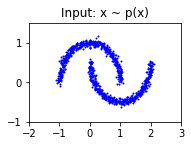

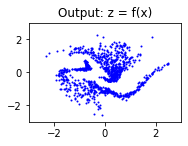

====> Test loss: -0.0547


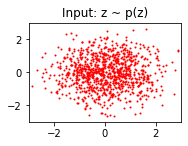

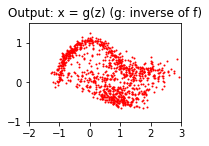

Train Epoch: 2 [0/50000 (0%)]	Loss: -0.052570
Train Epoch: 2 [6400/50000 (13%)]	Loss: -0.053561
Train Epoch: 2 [12800/50000 (26%)]	Loss: -0.054124
Train Epoch: 2 [19200/50000 (38%)]	Loss: -0.054575
Train Epoch: 2 [25600/50000 (51%)]	Loss: -0.054261
Train Epoch: 2 [32000/50000 (64%)]	Loss: -0.054461
Train Epoch: 2 [38400/50000 (77%)]	Loss: -0.055083
Train Epoch: 2 [44800/50000 (90%)]	Loss: -0.054099
====> Epoch: 2 Average train loss: -0.0545


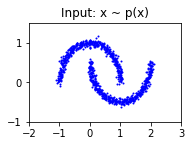

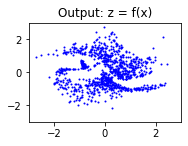

====> Test loss: -0.0570


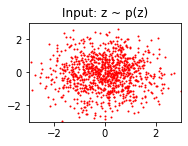

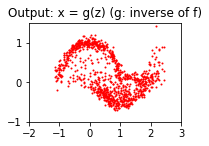

Train Epoch: 3 [0/50000 (0%)]	Loss: -0.055204
Train Epoch: 3 [6400/50000 (13%)]	Loss: -0.055435
Train Epoch: 3 [12800/50000 (26%)]	Loss: -0.055068
Train Epoch: 3 [19200/50000 (38%)]	Loss: -0.055954
Train Epoch: 3 [25600/50000 (51%)]	Loss: -0.055646
Train Epoch: 3 [32000/50000 (64%)]	Loss: -0.055340
Train Epoch: 3 [38400/50000 (77%)]	Loss: -0.055700
Train Epoch: 3 [44800/50000 (90%)]	Loss: -0.055573
====> Epoch: 3 Average train loss: -0.0555


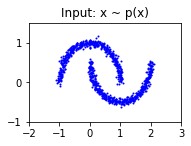

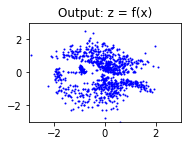

====> Test loss: -0.0573


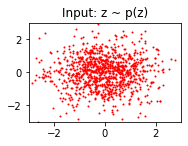

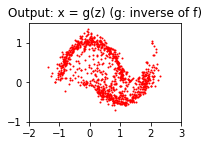

Train Epoch: 4 [0/50000 (0%)]	Loss: -0.056271
Train Epoch: 4 [6400/50000 (13%)]	Loss: -0.056074
Train Epoch: 4 [12800/50000 (26%)]	Loss: -0.055824
Train Epoch: 4 [19200/50000 (38%)]	Loss: -0.055665
Train Epoch: 4 [25600/50000 (51%)]	Loss: -0.056262
Train Epoch: 4 [32000/50000 (64%)]	Loss: -0.056760
Train Epoch: 4 [38400/50000 (77%)]	Loss: -0.057075
Train Epoch: 4 [44800/50000 (90%)]	Loss: -0.056193
====> Epoch: 4 Average train loss: -0.0563


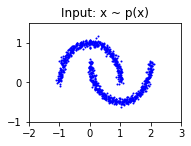

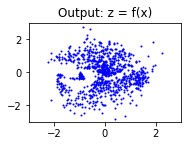

====> Test loss: -0.0581


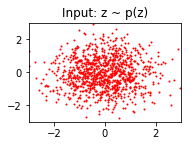

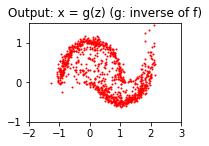

Train Epoch: 5 [0/50000 (0%)]	Loss: -0.058110
Train Epoch: 5 [6400/50000 (13%)]	Loss: -0.057721
Train Epoch: 5 [12800/50000 (26%)]	Loss: -0.055300
Train Epoch: 5 [19200/50000 (38%)]	Loss: -0.055972
Train Epoch: 5 [25600/50000 (51%)]	Loss: -0.057009
Train Epoch: 5 [32000/50000 (64%)]	Loss: -0.056483
Train Epoch: 5 [38400/50000 (77%)]	Loss: -0.056653
Train Epoch: 5 [44800/50000 (90%)]	Loss: -0.056330
====> Epoch: 5 Average train loss: -0.0568


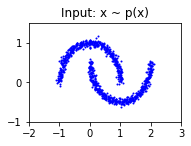

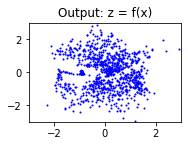

====> Test loss: -0.0589


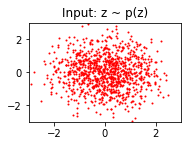

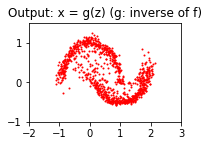

Train Epoch: 6 [0/50000 (0%)]	Loss: -0.056707
Train Epoch: 6 [6400/50000 (13%)]	Loss: -0.057769
Train Epoch: 6 [12800/50000 (26%)]	Loss: -0.056886
Train Epoch: 6 [19200/50000 (38%)]	Loss: -0.056936
Train Epoch: 6 [25600/50000 (51%)]	Loss: -0.056626
Train Epoch: 6 [32000/50000 (64%)]	Loss: -0.057151
Train Epoch: 6 [38400/50000 (77%)]	Loss: -0.057412
Train Epoch: 6 [44800/50000 (90%)]	Loss: -0.057986
====> Epoch: 6 Average train loss: -0.0572


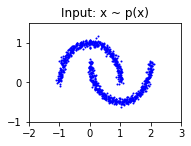

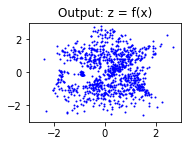

====> Test loss: -0.0585


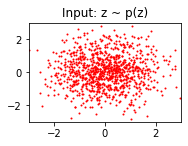

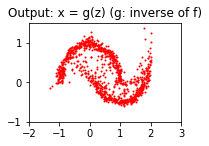

Train Epoch: 7 [0/50000 (0%)]	Loss: -0.056473
Train Epoch: 7 [6400/50000 (13%)]	Loss: -0.057551
Train Epoch: 7 [12800/50000 (26%)]	Loss: -0.056662
Train Epoch: 7 [19200/50000 (38%)]	Loss: -0.057399
Train Epoch: 7 [25600/50000 (51%)]	Loss: -0.057455
Train Epoch: 7 [32000/50000 (64%)]	Loss: -0.057780
Train Epoch: 7 [38400/50000 (77%)]	Loss: -0.056984
Train Epoch: 7 [44800/50000 (90%)]	Loss: -0.057141
====> Epoch: 7 Average train loss: -0.0573


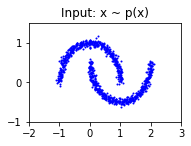

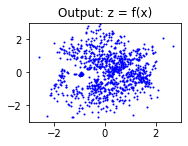

====> Test loss: -0.0591


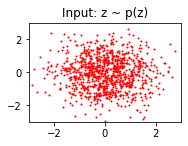

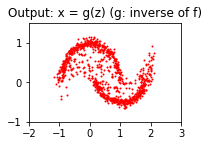

Train Epoch: 8 [0/50000 (0%)]	Loss: -0.056198
Train Epoch: 8 [6400/50000 (13%)]	Loss: -0.057404
Train Epoch: 8 [12800/50000 (26%)]	Loss: -0.057848
Train Epoch: 8 [19200/50000 (38%)]	Loss: -0.057244
Train Epoch: 8 [25600/50000 (51%)]	Loss: -0.057751
Train Epoch: 8 [32000/50000 (64%)]	Loss: -0.058139
Train Epoch: 8 [38400/50000 (77%)]	Loss: -0.056072
Train Epoch: 8 [44800/50000 (90%)]	Loss: -0.057712
====> Epoch: 8 Average train loss: -0.0575


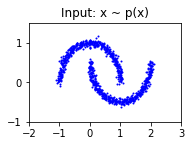

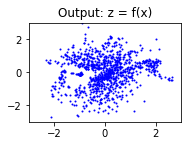

====> Test loss: -0.0589


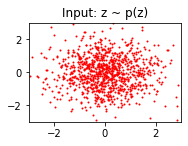

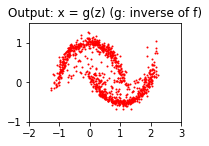

Train Epoch: 9 [0/50000 (0%)]	Loss: -0.056399
Train Epoch: 9 [6400/50000 (13%)]	Loss: -0.057650
Train Epoch: 9 [12800/50000 (26%)]	Loss: -0.058309
Train Epoch: 9 [19200/50000 (38%)]	Loss: -0.057230
Train Epoch: 9 [25600/50000 (51%)]	Loss: -0.058359
Train Epoch: 9 [32000/50000 (64%)]	Loss: -0.058125
Train Epoch: 9 [38400/50000 (77%)]	Loss: -0.057796
Train Epoch: 9 [44800/50000 (90%)]	Loss: -0.057388
====> Epoch: 9 Average train loss: -0.0577


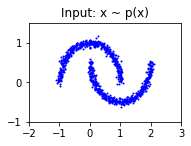

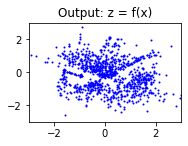

====> Test loss: -0.0587


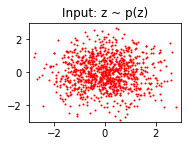

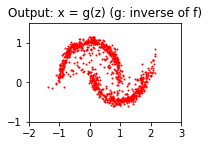

Train Epoch: 10 [0/50000 (0%)]	Loss: -0.057380
Train Epoch: 10 [6400/50000 (13%)]	Loss: -0.058268
Train Epoch: 10 [12800/50000 (26%)]	Loss: -0.058005
Train Epoch: 10 [19200/50000 (38%)]	Loss: -0.057573
Train Epoch: 10 [25600/50000 (51%)]	Loss: -0.056695
Train Epoch: 10 [32000/50000 (64%)]	Loss: -0.059147
Train Epoch: 10 [38400/50000 (77%)]	Loss: -0.058241
Train Epoch: 10 [44800/50000 (90%)]	Loss: -0.057463
====> Epoch: 10 Average train loss: -0.0578


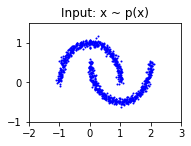

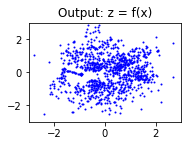

====> Test loss: -0.0593


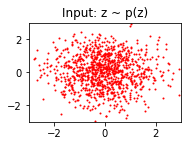

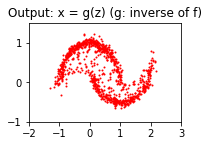

'156.87s'

<Figure size 432x288 with 0 Axes>

In [184]:
from timeit import default_timer as timer
# run
start = timer()
for epoch in range(1, N_EPOCHS + 1):
    train(epoch, model, optimizer, prior_z, train_loader)
    test(epoch, model, prior_z, test_loader)
    sample(epoch, model, prior_z)
f"{timer() - start:.02f}s"

**Q19: Explain why Normalizing flows do not fit well when there are many clusters in data**

> Let's give several intuitions why Normalizing flows do not fit well numerous clusters in data. 

> 1. Let's first take an extreme case in which our data is clustered in 4 distinct points, and every sample is assigned to one of these 4 points. There is no bijective mapping $f^{-1}$ such that $p_\mathcal{N}(z)=p_D(f^{-1}(z))$ for all z and our model will never converge.

> 2. Now let's take a less extreme and more realistic case in which our data has 4 distinct clusters in which all samples are distinct. There exists a bijective mapping $f^{-1}$ but this mapping will be "close" to being non bijective as it brings points that are far away in $\mathcal{Z}$ very close in $\mathcal{X}$. As a result $\frac{1}{\det(|J_{f}|)}= \det(|J_{f^{-1}}|) \simeq 0$ and therefore $-log(\det(|J_{f}|)) \simeq -\infty$ meaning that the loss is very hard to minimize as its minimum is a large negative value. Let's interpret this phenomenon : The Jacobian of $f^{-1}$ at a point gives the best linear approximation of the distorted n-dimensional cube near that point and the Jacobian determinant gives the ratio of the volumes of the approximating cube to that of the original cube. In other words, the det of the Jacobian accounts for changes of volume of infinitesimal cubes. Now as we said if our data has many clusters, our mapping $f^{-1}$ will bring close in $\mathcal{X}$ points that are far away in $\mathcal{Z}$. These changes of volumes will therefore be very small for $f^{-1}$, but very big for $f$ as it tries to bring these points that are close in $\mathcal{X}$ far away in $\mathcal{Z}$ This explains why $-log(\det(|J_{f}|)) \simeq -\infty$. 

> 3. Now using the second point, we understand that the loss is easier to minimize if $-log(\det(|J_{f}|)) \simeq 0$. Our model Normalizing flows therefore fit data for which $\det(|J_{f}|) \simeq 1$ meaning for volume-preserving transformations of gaussian densities.

Let's illustrate this phenomenon :

In [202]:
import os

import matplotlib.pyplot as plt
import numpy as np
import torch


def train_blobs(epoch, model, optimizer, prior_z, train_loader, log_interval=50):
    model.train()
    train_loss = 0
    for batch_idx, x_inputs in enumerate(train_loader):
        optimizer.zero_grad()
        z_outputs, log_det_j_sum = model.forward(x_inputs)  # train with the forward
        loss = -(prior_z.log_prob(z_outputs)+log_det_j_sum).mean()  # CRITICAL
        loss.backward()
        cur_loss = loss.item()
        train_loss += cur_loss
        optimizer.step()
        if batch_idx % log_interval == 0:
            print("Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}".format(
                epoch, batch_idx * len(x_inputs), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), cur_loss / len(x_inputs)))

    average_train_loss = train_loss / len(train_loader.dataset)
    print(f"====> Epoch: {epoch} Average train loss: {average_train_loss:.4f}")


def test_blobs(epoch, model, prior_z, test_loader):
    model.eval()
    test_loss = 0
    x_all = np.array([[]]).reshape(0, 2)
    z_all = np.array([[]]).reshape(0, 2)
    with torch.no_grad():
        for batch_idx, x_inputs in enumerate(test_loader):
            z_outputs, log_det_j_sum = model.forward(x_inputs)
            cur_loss = -(prior_z.log_prob(z_outputs)+log_det_j_sum).mean().item()
            test_loss += cur_loss
            x_all = np.concatenate((x_all, x_inputs.numpy()))
            z_all = np.concatenate((z_all, z_outputs.numpy()))

        subfig_plot(1, x_all, -5, 5, -5, 5, "Input: x ~ p(x)", "b")
        subfig_plot(2, z_all, -5, 5, -5, 5, "Output: z = f(x)", "b")

        test_loss /= len(test_loader.dataset)
        print(f"====> Test loss: {test_loss:.4f}")


def sample_blobs(epoch, model, prior_z, save_plt_interval=5):
    model.eval()
    with torch.no_grad():
        z_inputs = prior_z.sample((1000,))
        x_outputs = model.inverse(z_inputs)  # generation with the inverse
        z_inputs = z_inputs.numpy()
        x_outputs = x_outputs.numpy()

        subfig_plot(3, z_inputs, -5, 5, -5, 5, "Input: z ~ p(z)", "r")
        subfig_plot(4, x_outputs, -5, 5, -5, 5, "Output: x = g(z) (g: inverse of f)", "r")

        if epoch % save_plt_interval == 0:
            if not os.path.exists("results"):
                os.makedirs("results")
            plt.savefig("results/"+"result_"+str(epoch)+".png")

In [207]:
def train_with_blobs(centers, cluster_std):
    train_data = datasets.make_blobs(n_samples=50000, centers = centers, cluster_std = cluster_std, center_box = (-2,2))[0].astype(np.float32)
    test_data = datasets.make_blobs(n_samples=1000, centers = centers, cluster_std = cluster_std, center_box = (-2,2))[0].astype(np.float32)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    loader_kwargs = {"num_workers": 1, "pin_memory": True} if device == "cuda" else {}
    train_loader = torch.utils.data.DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True, **loader_kwargs)
    test_loader = torch.utils.data.DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=True, **loader_kwargs)

    from torch import distributions # optim, 
    # model construction
    mask = torch.from_numpy(np.array([0, 1]).astype(np.float32))
    model = RealNVP(INPUT_SIZE, OUTPUT_SIZE, HIDDEN_SIZE, mask, N_COUPLING_LAYERS)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
    prior_z = distributions.MultivariateNormal(torch.zeros(2), torch.eye(2))

    from timeit import default_timer as timer
    # run
    start = timer()
    for epoch in range(1, N_EPOCHS + 1):
        train_blobs(epoch, model, optimizer, prior_z, train_loader)
        test_blobs(epoch, model, prior_z, test_loader)
        sample_blobs(epoch, model, prior_z)
    f"{timer() - start:.02f}s"

Train Epoch: 1 [0/50000 (0%)]	Loss: 0.027204
Train Epoch: 1 [6400/50000 (13%)]	Loss: -0.041573
Train Epoch: 1 [12800/50000 (26%)]	Loss: -0.043495
Train Epoch: 1 [19200/50000 (38%)]	Loss: -0.044985
Train Epoch: 1 [25600/50000 (51%)]	Loss: -0.047195
Train Epoch: 1 [32000/50000 (64%)]	Loss: -0.047741
Train Epoch: 1 [38400/50000 (77%)]	Loss: -0.046740
Train Epoch: 1 [44800/50000 (90%)]	Loss: -0.048378
====> Epoch: 1 Average train loss: -0.0436


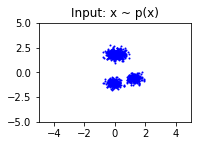

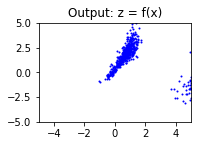

====> Test loss: 0.0998


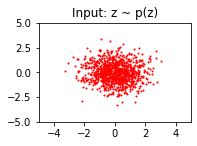

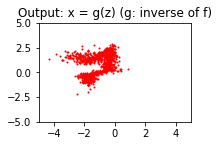

Train Epoch: 2 [0/50000 (0%)]	Loss: -0.047924
Train Epoch: 2 [6400/50000 (13%)]	Loss: -0.047749
Train Epoch: 2 [12800/50000 (26%)]	Loss: -0.048333
Train Epoch: 2 [19200/50000 (38%)]	Loss: -0.046726
Train Epoch: 2 [25600/50000 (51%)]	Loss: -0.049363
Train Epoch: 2 [32000/50000 (64%)]	Loss: -0.048044
Train Epoch: 2 [38400/50000 (77%)]	Loss: -0.049163
Train Epoch: 2 [44800/50000 (90%)]	Loss: -0.048054
====> Epoch: 2 Average train loss: -0.0482


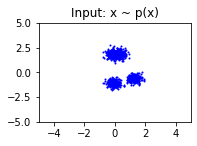

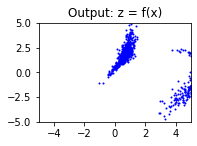

====> Test loss: 0.0576


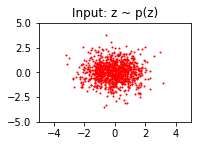

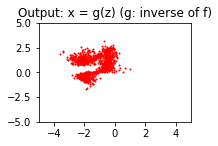

Train Epoch: 3 [0/50000 (0%)]	Loss: -0.048565
Train Epoch: 3 [6400/50000 (13%)]	Loss: -0.047982
Train Epoch: 3 [12800/50000 (26%)]	Loss: -0.049057
Train Epoch: 3 [19200/50000 (38%)]	Loss: -0.048032
Train Epoch: 3 [25600/50000 (51%)]	Loss: -0.049080
Train Epoch: 3 [32000/50000 (64%)]	Loss: -0.048143
Train Epoch: 3 [38400/50000 (77%)]	Loss: -0.047452
Train Epoch: 3 [44800/50000 (90%)]	Loss: -0.047925
====> Epoch: 3 Average train loss: -0.0485


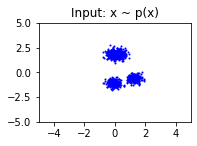

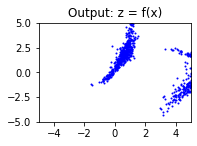

====> Test loss: 0.0373


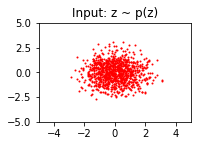

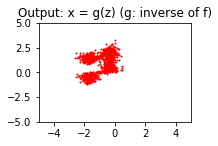

Train Epoch: 4 [0/50000 (0%)]	Loss: -0.048819
Train Epoch: 4 [6400/50000 (13%)]	Loss: -0.048933
Train Epoch: 4 [12800/50000 (26%)]	Loss: -0.048926
Train Epoch: 4 [19200/50000 (38%)]	Loss: -0.047941
Train Epoch: 4 [25600/50000 (51%)]	Loss: -0.048239
Train Epoch: 4 [32000/50000 (64%)]	Loss: -0.047874
Train Epoch: 4 [38400/50000 (77%)]	Loss: -0.048961
Train Epoch: 4 [44800/50000 (90%)]	Loss: -0.048577
====> Epoch: 4 Average train loss: -0.0487


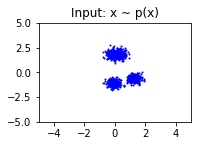

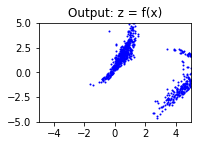

====> Test loss: 0.0314


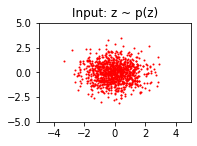

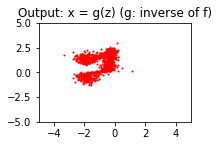

Train Epoch: 5 [0/50000 (0%)]	Loss: -0.050039
Train Epoch: 5 [6400/50000 (13%)]	Loss: -0.049754
Train Epoch: 5 [12800/50000 (26%)]	Loss: -0.048759
Train Epoch: 5 [19200/50000 (38%)]	Loss: -0.047578
Train Epoch: 5 [25600/50000 (51%)]	Loss: -0.048019
Train Epoch: 5 [32000/50000 (64%)]	Loss: -0.048957
Train Epoch: 5 [38400/50000 (77%)]	Loss: -0.048186
Train Epoch: 5 [44800/50000 (90%)]	Loss: -0.048166
====> Epoch: 5 Average train loss: -0.0487


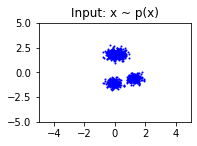

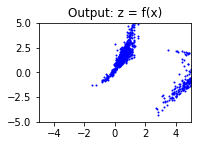

====> Test loss: 0.0395


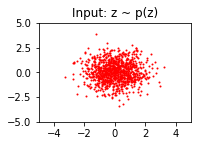

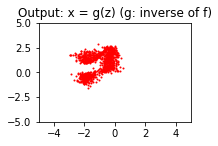

Train Epoch: 6 [0/50000 (0%)]	Loss: -0.047905
Train Epoch: 6 [6400/50000 (13%)]	Loss: -0.047071
Train Epoch: 6 [12800/50000 (26%)]	Loss: -0.047701
Train Epoch: 6 [19200/50000 (38%)]	Loss: -0.048604
Train Epoch: 6 [25600/50000 (51%)]	Loss: -0.049602
Train Epoch: 6 [32000/50000 (64%)]	Loss: -0.048897
Train Epoch: 6 [38400/50000 (77%)]	Loss: -0.048928
Train Epoch: 6 [44800/50000 (90%)]	Loss: -0.048989
====> Epoch: 6 Average train loss: -0.0489


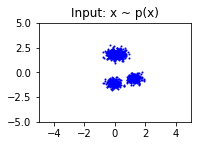

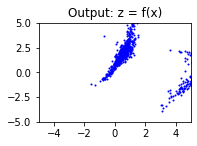

====> Test loss: 0.0573


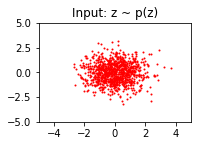

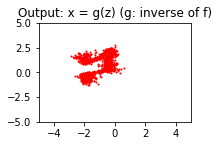

Train Epoch: 7 [0/50000 (0%)]	Loss: -0.049176
Train Epoch: 7 [6400/50000 (13%)]	Loss: -0.050208
Train Epoch: 7 [12800/50000 (26%)]	Loss: -0.048958
Train Epoch: 7 [19200/50000 (38%)]	Loss: -0.048949
Train Epoch: 7 [25600/50000 (51%)]	Loss: -0.048299
Train Epoch: 7 [32000/50000 (64%)]	Loss: -0.049367
Train Epoch: 7 [38400/50000 (77%)]	Loss: -0.049329
Train Epoch: 7 [44800/50000 (90%)]	Loss: -0.048224
====> Epoch: 7 Average train loss: -0.0490


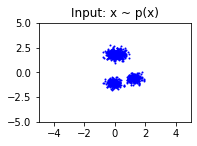

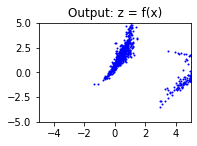

====> Test loss: 0.0608


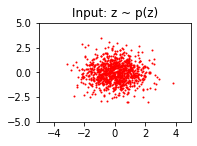

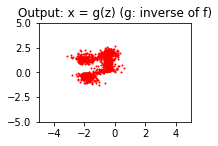

Train Epoch: 8 [0/50000 (0%)]	Loss: -0.049376
Train Epoch: 8 [6400/50000 (13%)]	Loss: -0.049807
Train Epoch: 8 [12800/50000 (26%)]	Loss: -0.049480
Train Epoch: 8 [19200/50000 (38%)]	Loss: -0.048062
Train Epoch: 8 [25600/50000 (51%)]	Loss: -0.048588
Train Epoch: 8 [32000/50000 (64%)]	Loss: -0.049562
Train Epoch: 8 [38400/50000 (77%)]	Loss: -0.049663
Train Epoch: 8 [44800/50000 (90%)]	Loss: -0.048821
====> Epoch: 8 Average train loss: -0.0489


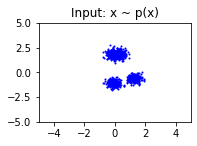

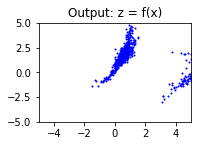

====> Test loss: 0.0795


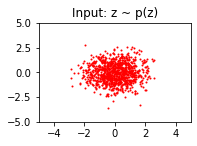

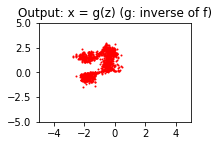

Train Epoch: 9 [0/50000 (0%)]	Loss: -0.048482
Train Epoch: 9 [6400/50000 (13%)]	Loss: -0.049482
Train Epoch: 9 [12800/50000 (26%)]	Loss: -0.049271
Train Epoch: 9 [19200/50000 (38%)]	Loss: -0.048316
Train Epoch: 9 [25600/50000 (51%)]	Loss: -0.048920
Train Epoch: 9 [32000/50000 (64%)]	Loss: -0.048642
Train Epoch: 9 [38400/50000 (77%)]	Loss: -0.048448
Train Epoch: 9 [44800/50000 (90%)]	Loss: -0.048248
====> Epoch: 9 Average train loss: -0.0490


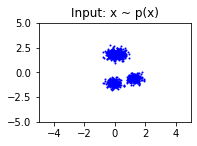

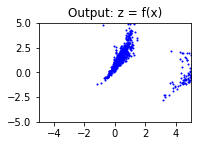

====> Test loss: 0.0633


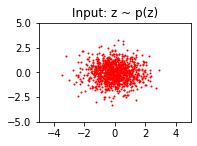

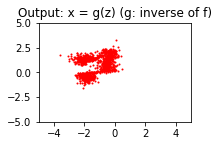

Train Epoch: 10 [0/50000 (0%)]	Loss: -0.049787
Train Epoch: 10 [6400/50000 (13%)]	Loss: -0.049095
Train Epoch: 10 [12800/50000 (26%)]	Loss: -0.048455
Train Epoch: 10 [19200/50000 (38%)]	Loss: -0.048260
Train Epoch: 10 [25600/50000 (51%)]	Loss: -0.048890
Train Epoch: 10 [32000/50000 (64%)]	Loss: -0.048707
Train Epoch: 10 [38400/50000 (77%)]	Loss: -0.048256
Train Epoch: 10 [44800/50000 (90%)]	Loss: -0.049261
====> Epoch: 10 Average train loss: -0.0490


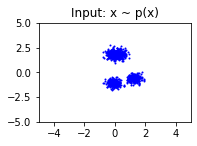

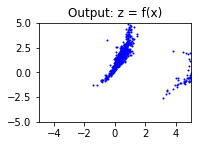

====> Test loss: 0.0950


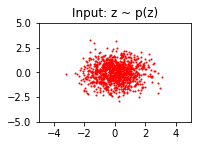

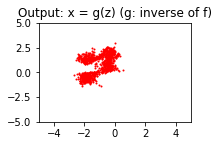

Train Epoch: 1 [0/50000 (0%)]	Loss: 0.034795
Train Epoch: 1 [6400/50000 (13%)]	Loss: -0.039067
Train Epoch: 1 [12800/50000 (26%)]	Loss: -0.041614
Train Epoch: 1 [19200/50000 (38%)]	Loss: -0.042710
Train Epoch: 1 [25600/50000 (51%)]	Loss: -0.042539
Train Epoch: 1 [32000/50000 (64%)]	Loss: -0.042352
Train Epoch: 1 [38400/50000 (77%)]	Loss: -0.045004
Train Epoch: 1 [44800/50000 (90%)]	Loss: -0.043761
====> Epoch: 1 Average train loss: -0.0401


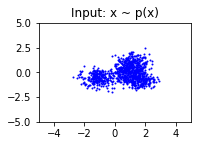

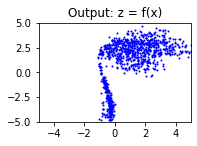

====> Test loss: -0.0079


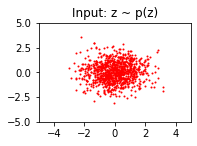

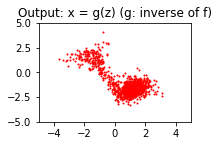

Train Epoch: 2 [0/50000 (0%)]	Loss: -0.043746
Train Epoch: 2 [6400/50000 (13%)]	Loss: -0.044260
Train Epoch: 2 [12800/50000 (26%)]	Loss: -0.043234
Train Epoch: 2 [19200/50000 (38%)]	Loss: -0.044105
Train Epoch: 2 [25600/50000 (51%)]	Loss: -0.044414
Train Epoch: 2 [32000/50000 (64%)]	Loss: -0.044072
Train Epoch: 2 [38400/50000 (77%)]	Loss: -0.042977
Train Epoch: 2 [44800/50000 (90%)]	Loss: -0.044025
====> Epoch: 2 Average train loss: -0.0444


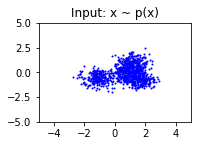

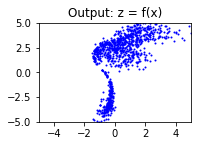

====> Test loss: -0.0050


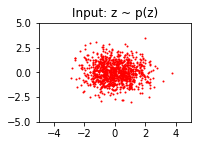

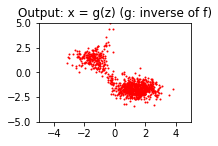

Train Epoch: 3 [0/50000 (0%)]	Loss: -0.044001
Train Epoch: 3 [6400/50000 (13%)]	Loss: -0.043146
Train Epoch: 3 [12800/50000 (26%)]	Loss: -0.043590
Train Epoch: 3 [19200/50000 (38%)]	Loss: -0.044502
Train Epoch: 3 [25600/50000 (51%)]	Loss: -0.044131
Train Epoch: 3 [32000/50000 (64%)]	Loss: -0.044691
Train Epoch: 3 [38400/50000 (77%)]	Loss: -0.044504
Train Epoch: 3 [44800/50000 (90%)]	Loss: -0.044695
====> Epoch: 3 Average train loss: -0.0448


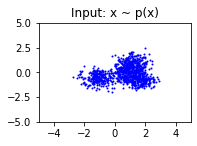

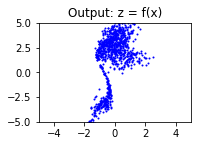

====> Test loss: -0.0056


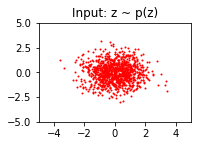

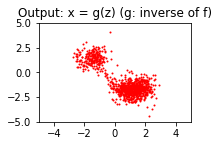

Train Epoch: 4 [0/50000 (0%)]	Loss: -0.043799
Train Epoch: 4 [6400/50000 (13%)]	Loss: -0.044708
Train Epoch: 4 [12800/50000 (26%)]	Loss: -0.043938
Train Epoch: 4 [19200/50000 (38%)]	Loss: -0.044975
Train Epoch: 4 [25600/50000 (51%)]	Loss: -0.043919
Train Epoch: 4 [32000/50000 (64%)]	Loss: -0.044617
Train Epoch: 4 [38400/50000 (77%)]	Loss: -0.045457
Train Epoch: 4 [44800/50000 (90%)]	Loss: -0.044192
====> Epoch: 4 Average train loss: -0.0449


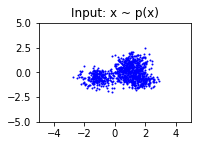

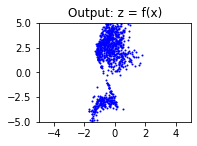

====> Test loss: -0.0042


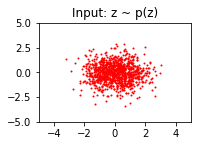

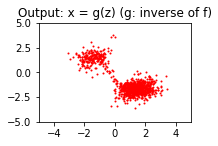

Train Epoch: 5 [0/50000 (0%)]	Loss: -0.045383
Train Epoch: 5 [6400/50000 (13%)]	Loss: -0.045230
Train Epoch: 5 [12800/50000 (26%)]	Loss: -0.044213
Train Epoch: 5 [19200/50000 (38%)]	Loss: -0.045112
Train Epoch: 5 [25600/50000 (51%)]	Loss: -0.044344
Train Epoch: 5 [32000/50000 (64%)]	Loss: -0.043639
Train Epoch: 5 [38400/50000 (77%)]	Loss: -0.044627
Train Epoch: 5 [44800/50000 (90%)]	Loss: -0.044458
====> Epoch: 5 Average train loss: -0.0450


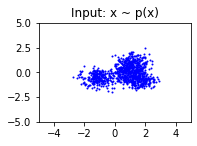

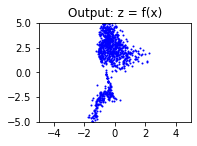

====> Test loss: -0.0058


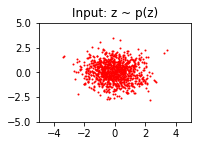

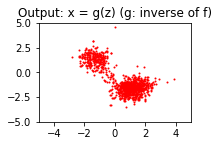

Train Epoch: 6 [0/50000 (0%)]	Loss: -0.044780
Train Epoch: 6 [6400/50000 (13%)]	Loss: -0.045272
Train Epoch: 6 [12800/50000 (26%)]	Loss: -0.044782
Train Epoch: 6 [19200/50000 (38%)]	Loss: -0.045027
Train Epoch: 6 [25600/50000 (51%)]	Loss: -0.045780
Train Epoch: 6 [32000/50000 (64%)]	Loss: -0.044507
Train Epoch: 6 [38400/50000 (77%)]	Loss: -0.043734
Train Epoch: 6 [44800/50000 (90%)]	Loss: -0.044517
====> Epoch: 6 Average train loss: -0.0450


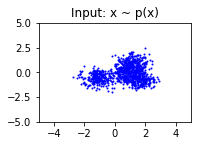

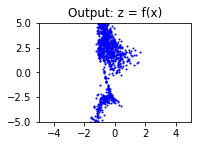

====> Test loss: -0.0038


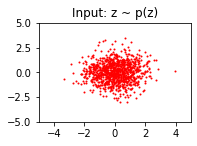

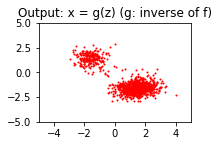

Train Epoch: 7 [0/50000 (0%)]	Loss: -0.044089
Train Epoch: 7 [6400/50000 (13%)]	Loss: -0.044557
Train Epoch: 7 [12800/50000 (26%)]	Loss: -0.044609
Train Epoch: 7 [19200/50000 (38%)]	Loss: -0.045014
Train Epoch: 7 [25600/50000 (51%)]	Loss: -0.044982
Train Epoch: 7 [32000/50000 (64%)]	Loss: -0.044057
Train Epoch: 7 [38400/50000 (77%)]	Loss: -0.044161
Train Epoch: 7 [44800/50000 (90%)]	Loss: -0.044505
====> Epoch: 7 Average train loss: -0.0451


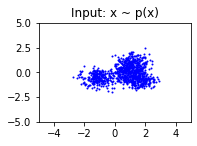

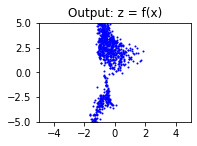

====> Test loss: 0.0068


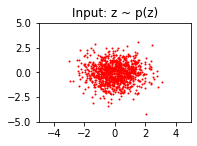

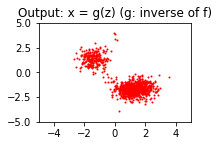

Train Epoch: 8 [0/50000 (0%)]	Loss: -0.044764
Train Epoch: 8 [6400/50000 (13%)]	Loss: -0.044974
Train Epoch: 8 [12800/50000 (26%)]	Loss: -0.045377
Train Epoch: 8 [19200/50000 (38%)]	Loss: -0.044702
Train Epoch: 8 [25600/50000 (51%)]	Loss: -0.045765
Train Epoch: 8 [32000/50000 (64%)]	Loss: -0.046117
Train Epoch: 8 [38400/50000 (77%)]	Loss: -0.044862
Train Epoch: 8 [44800/50000 (90%)]	Loss: -0.045152
====> Epoch: 8 Average train loss: -0.0451


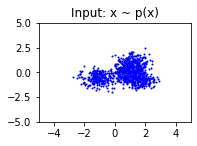

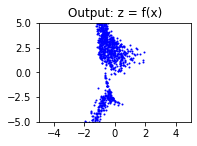

====> Test loss: 0.0054


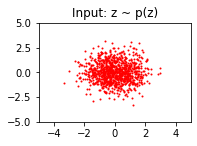

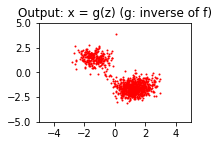

Train Epoch: 9 [0/50000 (0%)]	Loss: -0.044581
Train Epoch: 9 [6400/50000 (13%)]	Loss: -0.044679
Train Epoch: 9 [12800/50000 (26%)]	Loss: -0.045482
Train Epoch: 9 [19200/50000 (38%)]	Loss: -0.045409
Train Epoch: 9 [25600/50000 (51%)]	Loss: -0.045745
Train Epoch: 9 [32000/50000 (64%)]	Loss: -0.044204
Train Epoch: 9 [38400/50000 (77%)]	Loss: -0.045491
Train Epoch: 9 [44800/50000 (90%)]	Loss: -0.046151
====> Epoch: 9 Average train loss: -0.0451


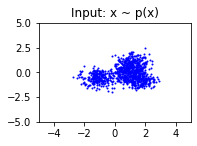

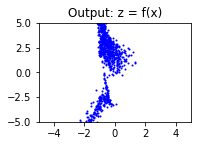

====> Test loss: 0.0076


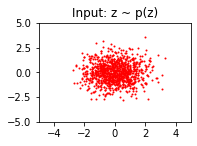

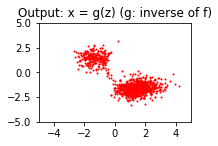

Train Epoch: 10 [0/50000 (0%)]	Loss: -0.045732
Train Epoch: 10 [6400/50000 (13%)]	Loss: -0.044540
Train Epoch: 10 [12800/50000 (26%)]	Loss: -0.044307
Train Epoch: 10 [19200/50000 (38%)]	Loss: -0.044334
Train Epoch: 10 [25600/50000 (51%)]	Loss: -0.045201
Train Epoch: 10 [32000/50000 (64%)]	Loss: -0.044789
Train Epoch: 10 [38400/50000 (77%)]	Loss: -0.044352
Train Epoch: 10 [44800/50000 (90%)]	Loss: -0.045451
====> Epoch: 10 Average train loss: -0.0451


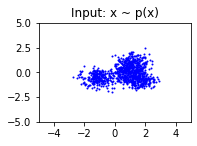

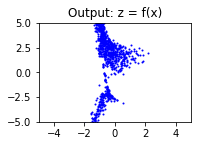

====> Test loss: 0.0053


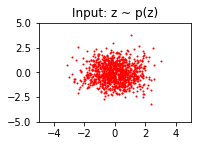

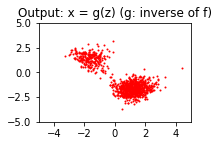

Train Epoch: 1 [0/50000 (0%)]	Loss: 0.024333
Train Epoch: 1 [6400/50000 (13%)]	Loss: -0.035825
Train Epoch: 1 [12800/50000 (26%)]	Loss: -0.035970
Train Epoch: 1 [19200/50000 (38%)]	Loss: -0.035815
Train Epoch: 1 [25600/50000 (51%)]	Loss: -0.035420
Train Epoch: 1 [32000/50000 (64%)]	Loss: -0.035993
Train Epoch: 1 [38400/50000 (77%)]	Loss: -0.036615
Train Epoch: 1 [44800/50000 (90%)]	Loss: -0.036142
====> Epoch: 1 Average train loss: -0.0338


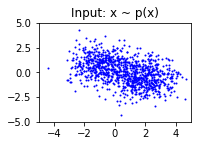

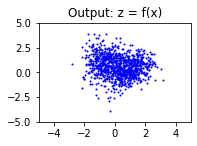

====> Test loss: -0.0338


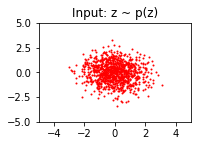

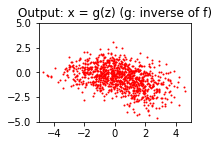

Train Epoch: 2 [0/50000 (0%)]	Loss: -0.034974
Train Epoch: 2 [6400/50000 (13%)]	Loss: -0.036519
Train Epoch: 2 [12800/50000 (26%)]	Loss: -0.036765
Train Epoch: 2 [19200/50000 (38%)]	Loss: -0.036823
Train Epoch: 2 [25600/50000 (51%)]	Loss: -0.036826
Train Epoch: 2 [32000/50000 (64%)]	Loss: -0.035282
Train Epoch: 2 [38400/50000 (77%)]	Loss: -0.036166
Train Epoch: 2 [44800/50000 (90%)]	Loss: -0.035009
====> Epoch: 2 Average train loss: -0.0362


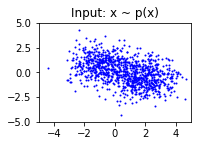

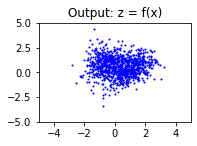

====> Test loss: -0.0340


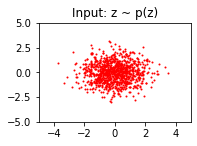

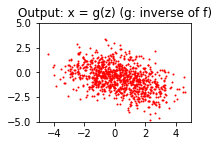

Train Epoch: 3 [0/50000 (0%)]	Loss: -0.036665
Train Epoch: 3 [6400/50000 (13%)]	Loss: -0.035254
Train Epoch: 3 [12800/50000 (26%)]	Loss: -0.036643
Train Epoch: 3 [19200/50000 (38%)]	Loss: -0.035522
Train Epoch: 3 [25600/50000 (51%)]	Loss: -0.036704
Train Epoch: 3 [32000/50000 (64%)]	Loss: -0.036262
Train Epoch: 3 [38400/50000 (77%)]	Loss: -0.036591
Train Epoch: 3 [44800/50000 (90%)]	Loss: -0.035315
====> Epoch: 3 Average train loss: -0.0363


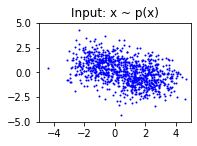

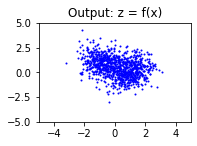

====> Test loss: -0.0342


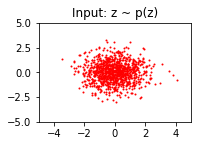

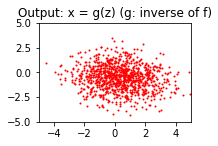

Train Epoch: 4 [0/50000 (0%)]	Loss: -0.036289
Train Epoch: 4 [6400/50000 (13%)]	Loss: -0.036228
Train Epoch: 4 [12800/50000 (26%)]	Loss: -0.035895
Train Epoch: 4 [19200/50000 (38%)]	Loss: -0.036467
Train Epoch: 4 [25600/50000 (51%)]	Loss: -0.036619
Train Epoch: 4 [32000/50000 (64%)]	Loss: -0.035940
Train Epoch: 4 [38400/50000 (77%)]	Loss: -0.035126
Train Epoch: 4 [44800/50000 (90%)]	Loss: -0.036690
====> Epoch: 4 Average train loss: -0.0363


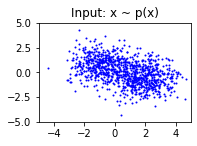

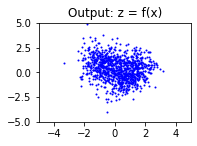

====> Test loss: -0.0348


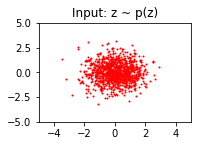

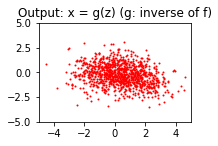

Train Epoch: 5 [0/50000 (0%)]	Loss: -0.035925
Train Epoch: 5 [6400/50000 (13%)]	Loss: -0.037114
Train Epoch: 5 [12800/50000 (26%)]	Loss: -0.035581
Train Epoch: 5 [19200/50000 (38%)]	Loss: -0.036617
Train Epoch: 5 [25600/50000 (51%)]	Loss: -0.037719
Train Epoch: 5 [32000/50000 (64%)]	Loss: -0.035326
Train Epoch: 5 [38400/50000 (77%)]	Loss: -0.036743
Train Epoch: 5 [44800/50000 (90%)]	Loss: -0.037659
====> Epoch: 5 Average train loss: -0.0363


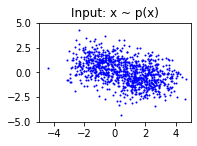

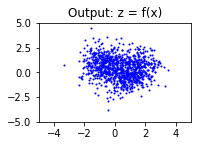

====> Test loss: -0.0344


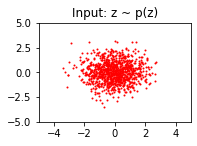

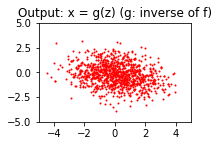

Train Epoch: 6 [0/50000 (0%)]	Loss: -0.036431
Train Epoch: 6 [6400/50000 (13%)]	Loss: -0.034841
Train Epoch: 6 [12800/50000 (26%)]	Loss: -0.036387
Train Epoch: 6 [19200/50000 (38%)]	Loss: -0.035805
Train Epoch: 6 [25600/50000 (51%)]	Loss: -0.037465
Train Epoch: 6 [32000/50000 (64%)]	Loss: -0.036278
Train Epoch: 6 [38400/50000 (77%)]	Loss: -0.036632
Train Epoch: 6 [44800/50000 (90%)]	Loss: -0.036766
====> Epoch: 6 Average train loss: -0.0363


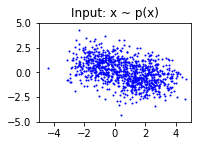

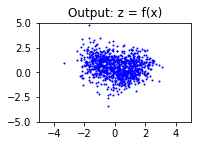

====> Test loss: -0.0343


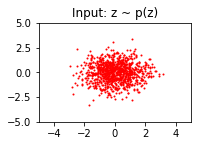

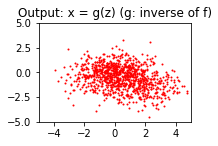

Train Epoch: 7 [0/50000 (0%)]	Loss: -0.035460
Train Epoch: 7 [6400/50000 (13%)]	Loss: -0.036882
Train Epoch: 7 [12800/50000 (26%)]	Loss: -0.035784
Train Epoch: 7 [19200/50000 (38%)]	Loss: -0.036455
Train Epoch: 7 [25600/50000 (51%)]	Loss: -0.036379
Train Epoch: 7 [32000/50000 (64%)]	Loss: -0.036418
Train Epoch: 7 [38400/50000 (77%)]	Loss: -0.036966
Train Epoch: 7 [44800/50000 (90%)]	Loss: -0.036679
====> Epoch: 7 Average train loss: -0.0363


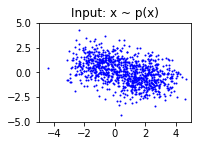

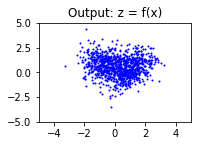

====> Test loss: -0.0342


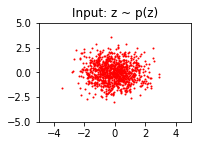

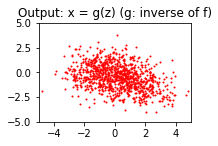

Train Epoch: 8 [0/50000 (0%)]	Loss: -0.035341
Train Epoch: 8 [6400/50000 (13%)]	Loss: -0.036293
Train Epoch: 8 [12800/50000 (26%)]	Loss: -0.036708
Train Epoch: 8 [19200/50000 (38%)]	Loss: -0.037103
Train Epoch: 8 [25600/50000 (51%)]	Loss: -0.037493
Train Epoch: 8 [32000/50000 (64%)]	Loss: -0.037259
Train Epoch: 8 [38400/50000 (77%)]	Loss: -0.037334
Train Epoch: 8 [44800/50000 (90%)]	Loss: -0.036663
====> Epoch: 8 Average train loss: -0.0364


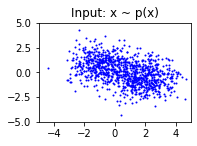

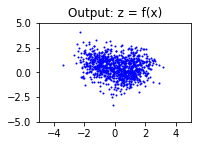

====> Test loss: -0.0344


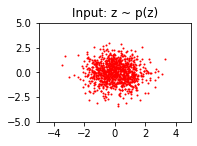

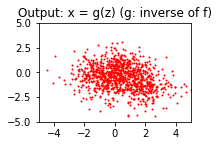

Train Epoch: 9 [0/50000 (0%)]	Loss: -0.036622
Train Epoch: 9 [6400/50000 (13%)]	Loss: -0.035443
Train Epoch: 9 [12800/50000 (26%)]	Loss: -0.036759
Train Epoch: 9 [19200/50000 (38%)]	Loss: -0.035576
Train Epoch: 9 [25600/50000 (51%)]	Loss: -0.035632
Train Epoch: 9 [32000/50000 (64%)]	Loss: -0.036652
Train Epoch: 9 [38400/50000 (77%)]	Loss: -0.037393
Train Epoch: 9 [44800/50000 (90%)]	Loss: -0.036034
====> Epoch: 9 Average train loss: -0.0364


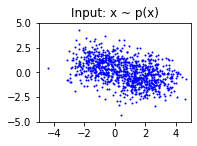

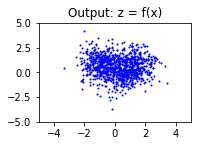

====> Test loss: -0.0343


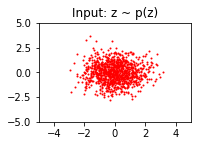

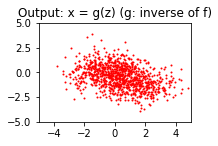

Train Epoch: 10 [0/50000 (0%)]	Loss: -0.036370
Train Epoch: 10 [6400/50000 (13%)]	Loss: -0.036447
Train Epoch: 10 [12800/50000 (26%)]	Loss: -0.036089
Train Epoch: 10 [19200/50000 (38%)]	Loss: -0.036368
Train Epoch: 10 [25600/50000 (51%)]	Loss: -0.036214
Train Epoch: 10 [32000/50000 (64%)]	Loss: -0.037100
Train Epoch: 10 [38400/50000 (77%)]	Loss: -0.036404
Train Epoch: 10 [44800/50000 (90%)]	Loss: -0.037314
====> Epoch: 10 Average train loss: -0.0364


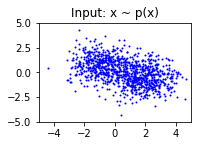

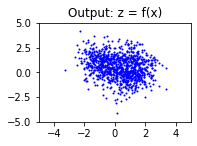

====> Test loss: -0.0339


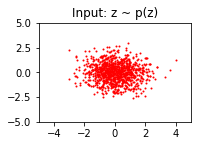

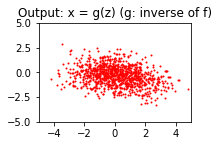

<Figure size 432x288 with 0 Axes>

In [208]:
train_with_blobs(4,0.25)
train_with_blobs(4,0.5)
train_with_blobs(4,1)

We clearly see that data that have a bigger standard deviation and that is less "clustered" is better fitted by Normalizing flows. 

**Q20: As a conclusion, how would you compare the advantages and shortcomings of GANs, VAEs and Normalizing flows?**

> (Write your answer here)